# Additional Cleaning and Exploration

### Imports

In [100]:
import pandas as pd
import seaborn as sns
import pandasql as ps
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost

### Source DataFrame
- Read
- Drop some columns

In [101]:
df = pd.read_csv("final_aggregated_df.csv")

In [102]:
df = df.drop(['is_monday','is_tuesday','is_wednesday','is_thursday','is_friday','is_saturday','is_sunday'], axis = 1)

### Check Data

In [103]:
df.shape

(12104, 116)

### Add the Missing Days
- Transform the date to a different format
- Include the missing days

In [104]:
date_dim = ps.sqldf("""
WITH RECURSIVE dates(date) AS (
  VALUES('2012-01-01')
  UNION ALL
  SELECT date(date, '+1 day')
  FROM dates
  WHERE date < '2016-12-31'
)
SELECT date FROM dates
""", locals())

date_dim.head()

date
0  2012-01-01
1  2012-01-02
2  2012-01-03
3  2012-01-04
4  2012-01-05

In [105]:
df = ps.sqldf("""

SELECT
  x.*,
  y.*
FROM
(SELECT
b.sector as sector_, a.date,
CASE WHEN strftime('%w', a.date) = "1" THEN 1 ELSE 0 END AS is_monday,
CASE WHEN strftime('%w', a.date) = "2" THEN 1 ELSE 0 END AS is_tuesday,
CASE WHEN strftime('%w', a.date) = "3" THEN 1 ELSE 0 END AS is_wednesday,
CASE WHEN strftime('%w', a.date) = "4" THEN 1 ELSE 0 END AS is_thursday,
CASE WHEN strftime('%w', a.date) = "5" THEN 1 ELSE 0 END AS is_friday,
CASE WHEN strftime('%w', a.date) = "6" THEN 1 ELSE 0 END AS is_saturday,
CASE WHEN strftime('%w', a.date) = "0" THEN 1 ELSE 0 END AS is_sunday
FROM date_dim a
CROSS JOIN (select 1 AS sector
UNION ALL select 2
UNION ALL select 3
UNION ALL select 4
UNION ALL select 5
UNION ALL select 6
UNION ALL select 7) b

) x
LEFT JOIN
df y on
SUBSTR(collision_date,1,10) = x.date
and y.sector = x.sector_
order by 1,2
""", locals())

In [106]:
df.head()

sector_        date  is_monday  is_tuesday  is_wednesday  is_thursday  \
0        1  2012-01-01          0           0             0            0   
1        1  2012-01-02          1           0             0            0   
2        1  2012-01-03          0           1             0            0   
3        1  2012-01-04          0           0             1            0   
4        1  2012-01-05          0           0             0            1   

   is_friday  is_saturday  is_sunday  Unnamed: 0           ...            \
0          0            0          1         0.0           ...             
1          0            0          0         1.0           ...             
2          0            0          0         2.0           ...             
3          0            0          0         3.0           ...             
4          0            0          0         4.0           ...             

   lighting_B lighting_C  lighting_D  lighting_E  lighting_Unknown  \
0         1.0        1.0         0.0         0.0               0.0   
1         0.0        2.0         1.0         0.0               0.0   
2         1.0        2.0         1.0         0.0               0.0   
3         0.0        2.0         1.0         0.0               0.0   
4         0.0        4.0         0.0         0.0               0.0   

   control_device_A  control_device_B  control_device_C  control_device_D  \
0               1.0               0.0               0.0               3.0   
1               2.0               0.0               0.0               4.0   
2               2.0               0.0               0.0               4.0   
3               1.0               0.0               0.0               4.0   
4               4.0               0.0               0.0               9.0   

   control_device_Unknown  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  

[5 rows x 125 columns]

### Impute and Drop Ends of Dataset

In [107]:
def impute_series(pd_df,target,window=15,min_periods=1,center=True):
    return(pd_df.fillna(pd_df.rolling(window=15,min_periods=1,center=True).mean())[target])

In [108]:
for column in ["collisions", "is_12AM_3AM", "is_3AM_6AM", "is_6AM_9AM", "is_9AM_12PM", "is_12PM_3PM", "is_3PM_6PM", "is_6PM_9PM", "is_9PM_12AM","high_severity", "low_severity", "number_killed", "number_injured", "pedestrian_accident", "bicycle_accident", "motorcycle_accident", "truck_accident", "alcohol_involved", "count_ped_killed", "count_ped_injured", "count_bicyclist_killed", "count_bicyclist_injured", "intersection_N", "intersection_Unknown", "intersection_Y", "location_type_H", "location_type_I", "location_type_N", "location_type_R", "primary_coll_factor_A", "primary_coll_factor_B", "primary_coll_factor_C", "primary_coll_factor_D", "primary_coll_factor_E", "primary_coll_factor_Unknown", "pcf_viol_category_00", "pcf_viol_category_01", "pcf_viol_category_02", "pcf_viol_category_03", "pcf_viol_category_04", "pcf_viol_category_05", "pcf_viol_category_06", "pcf_viol_category_07", "pcf_viol_category_08", "pcf_viol_category_09", "pcf_viol_category_10", "pcf_viol_category_11", "pcf_viol_category_12", "pcf_viol_category_13", "pcf_viol_category_14", "pcf_viol_category_15", "pcf_viol_category_16", "pcf_viol_category_17", "pcf_viol_category_18", "pcf_viol_category_21", "pcf_viol_category_22", "pcf_viol_category_24", "pcf_viol_category_Unknown", "hit_and_run_F", "hit_and_run_M", "hit_and_run_N", "type_of_collision_A", "type_of_collision_B", "type_of_collision_C", "type_of_collision_D", "type_of_collision_E", "type_of_collision_F", "type_of_collision_G", "type_of_collision_H", "type_of_collision_Unknown", "road_surface_A", "road_surface_B", "road_surface_C", "road_surface_D", "road_surface_Unknown", "road_cond_1_A", "road_cond_1_B", "road_cond_1_C", "road_cond_1_D", "road_cond_1_E", "road_cond_1_F", "road_cond_1_G", "road_cond_1_H", "road_cond_1_Unknown", "lighting_A", "lighting_B", "lighting_C", "lighting_D", "lighting_E", "lighting_Unknown", "control_device_A", "control_device_B", "control_device_C", "control_device_D", "control_device_Unknown"]:
    df[column] = df.fillna(0)[column]

    

In [109]:
for column in ["avg_density_per_collision", "avg_wealth_per_collision", "avg_intersections_per_collision", "avg_watts_per_collision", "avg_lightbulbs_per_collision", "avg_one_way_signs_per_collision", "avg_speed_limit_signs_per_collision", "avg_no_u_turn_signs_per_collision", "avg_stop_sign_per_collision", "avg_yield_sign_per_collision", "weather_1_A", "weather_1_B", "weather_1_C", "weather_1_D", "weather_1_E", "weather_1_F", "weather_1_G", "weather_1_Unknown"]:
    df[column] = impute_series(df, target=column)
    

In [110]:
df = ps.sqldf("""select * from df order by date, sector_""")

### Change Point
There is a change point at the end of the dataset as seen by this plot.  Therefore, the last few months of data have been dropped.

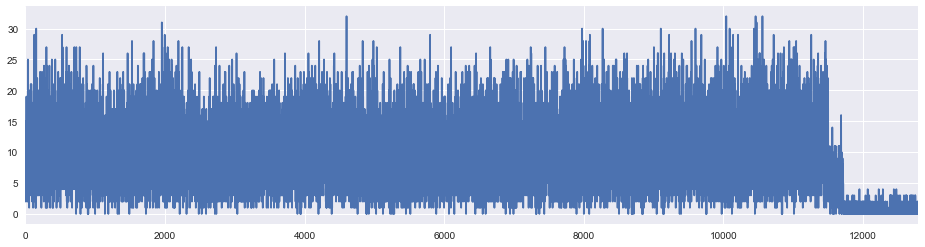

In [111]:
df['collisions'].plot(figsize=(16, 4))

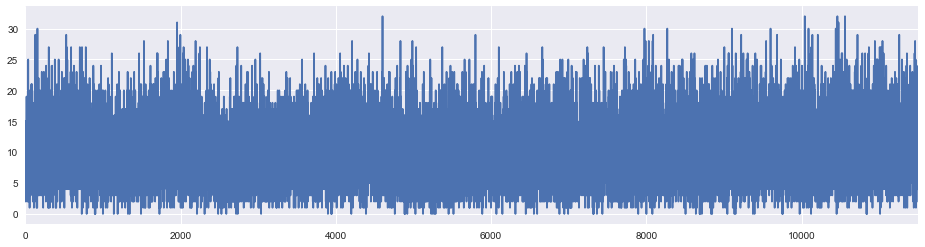

In [112]:
df['collisions'].iloc[0:11501].plot(figsize=(16, 4))

In [113]:
df = df.iloc[0:11501]

In [114]:
# # Two subplots, the axes array is 1-d
# f, axarr = plt.subplots(7, sharex=True)
# axarr[0].plot(x="date", y=ps.sqldf("""SELECT * from df where sector_ = 1""", locals())['collisions'])
# axarr[0].set_title('Sharing X axis')
# axarr[1].plot(x="date", y=ps.sqldf("""SELECT * from df where sector_ = 2""", locals())['collisions'])


plot_df = ps.sqldf("""
SELECT
  date,
  MAX(CASE WHEN sector_ = 1 THEN collisions ELSE 0 END) AS sector1,
  MAX(CASE WHEN sector_ = 2 THEN collisions ELSE 0 END) AS sector2,
  MAX(CASE WHEN sector_ = 3 THEN collisions ELSE 0 END) AS sector3,
  MAX(CASE WHEN sector_ = 4 THEN collisions ELSE 0 END) AS sector4,
  MAX(CASE WHEN sector_ = 5 THEN collisions ELSE 0 END) AS sector5,
  MAX(CASE WHEN sector_ = 6 THEN collisions ELSE 0 END) AS sector6,
  MAX(CASE WHEN sector_ = 7 THEN collisions ELSE 0 END) AS sector7
FROM df
GROUP BY 1
order by 1
""")


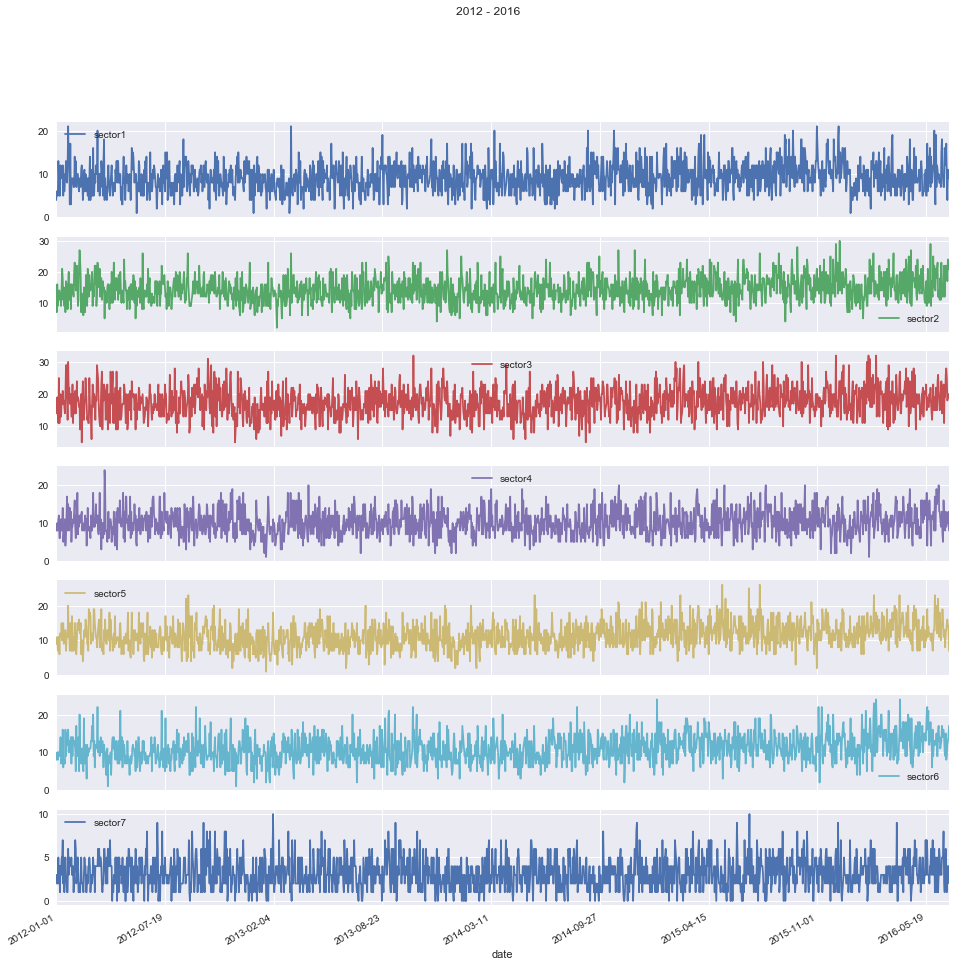

In [115]:
plot_df.plot(x="date", subplots=True, figsize=(16, 16), title="2012 - 2016");

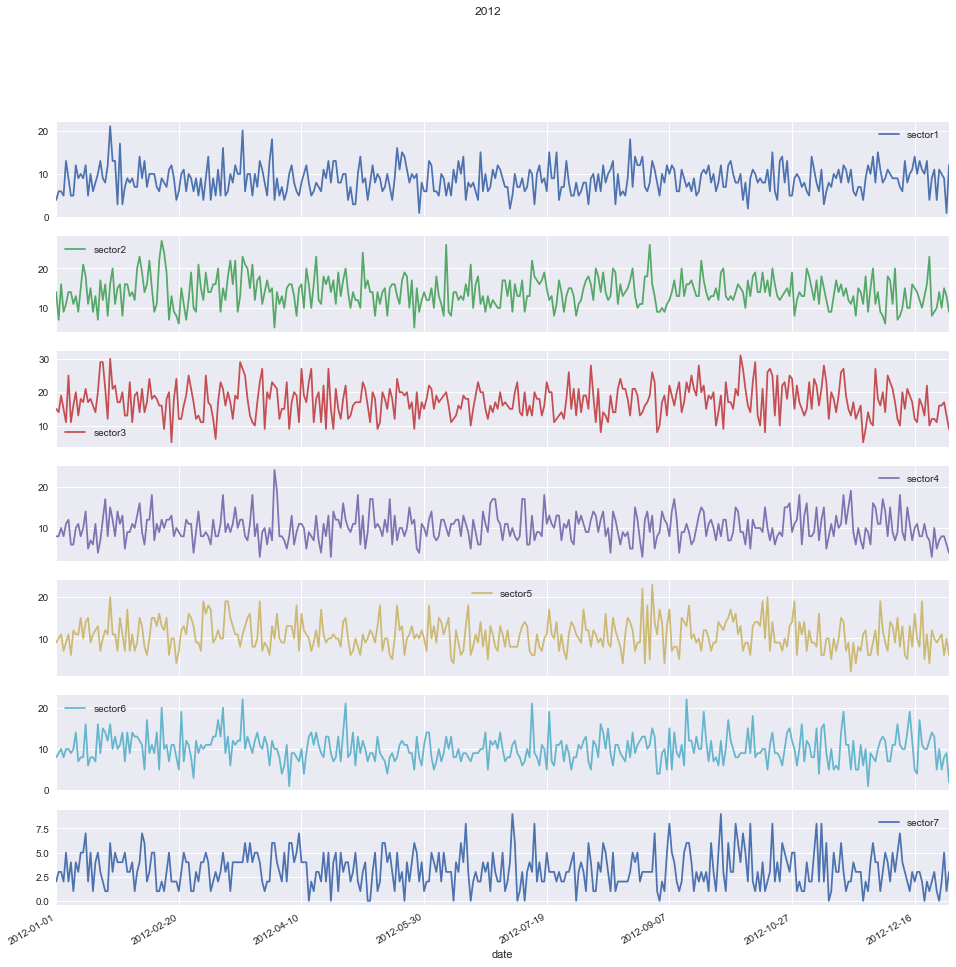

In [116]:
plot_df.iloc[0:365].plot(x="date", subplots=True, figsize=(16, 16), title="2012");

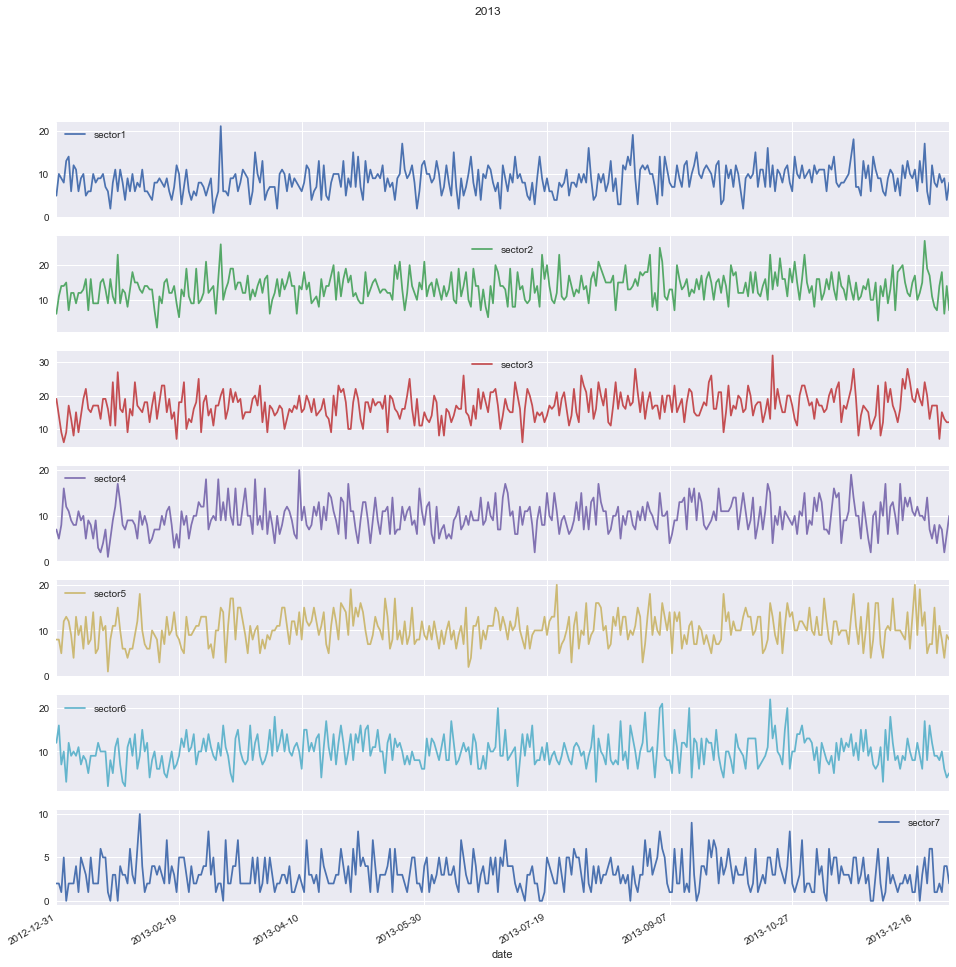

In [117]:
plot_df.iloc[365:730].plot(x="date", subplots=True, figsize=(16, 16), title="2013");

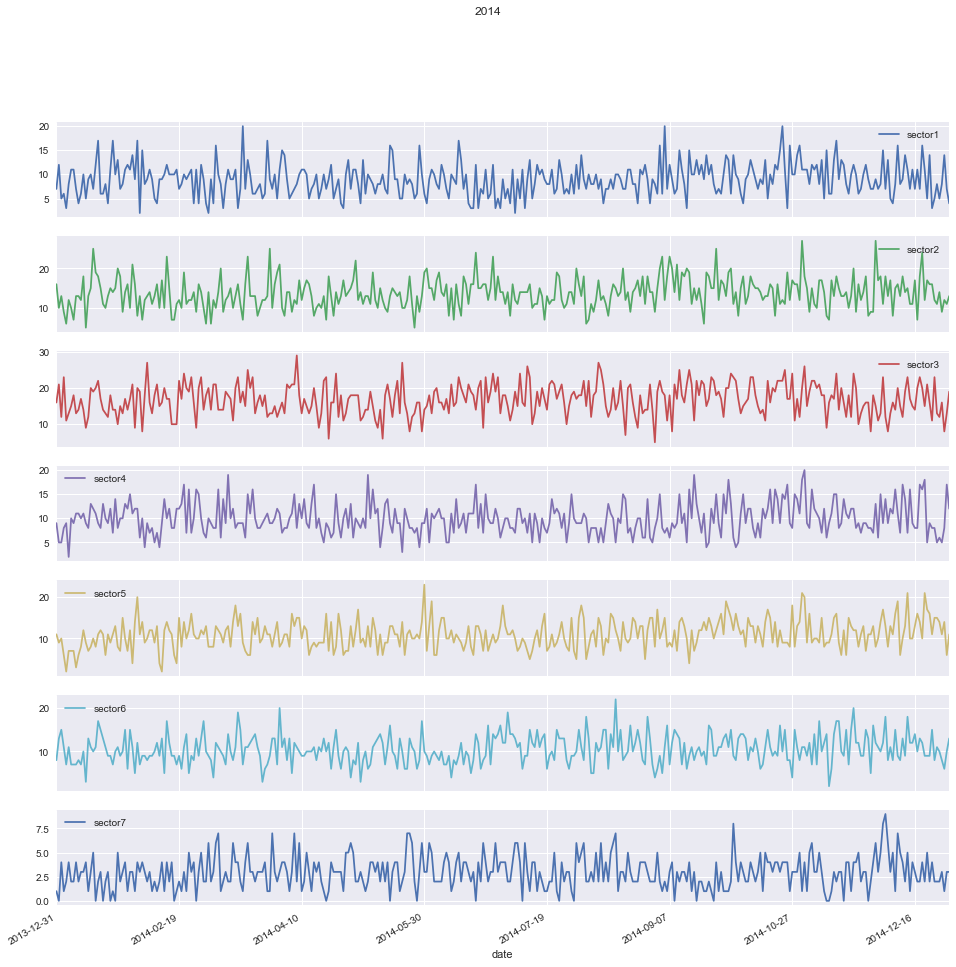

In [118]:
plot_df.iloc[730:1095].plot(x="date", subplots=True, figsize=(16, 16), title="2014");

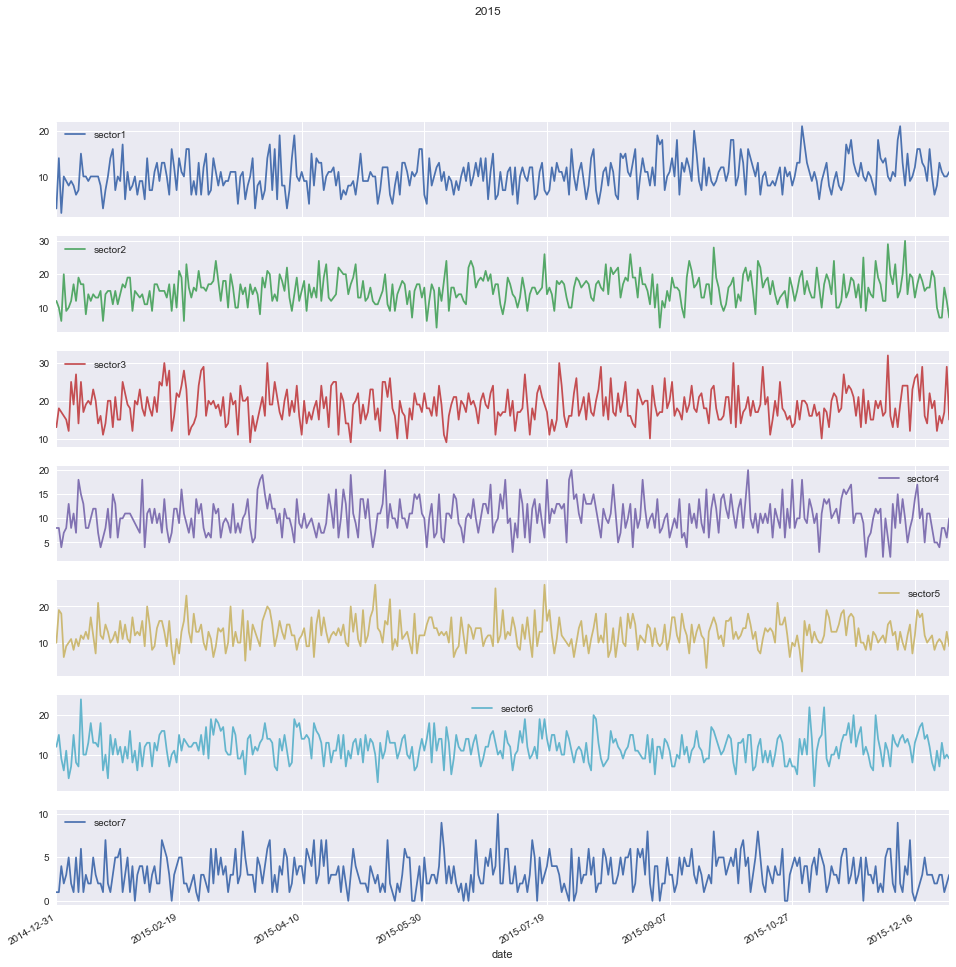

In [119]:
plot_df.iloc[1095:1460].plot(x="date", subplots=True, figsize=(16, 16), title="2015");

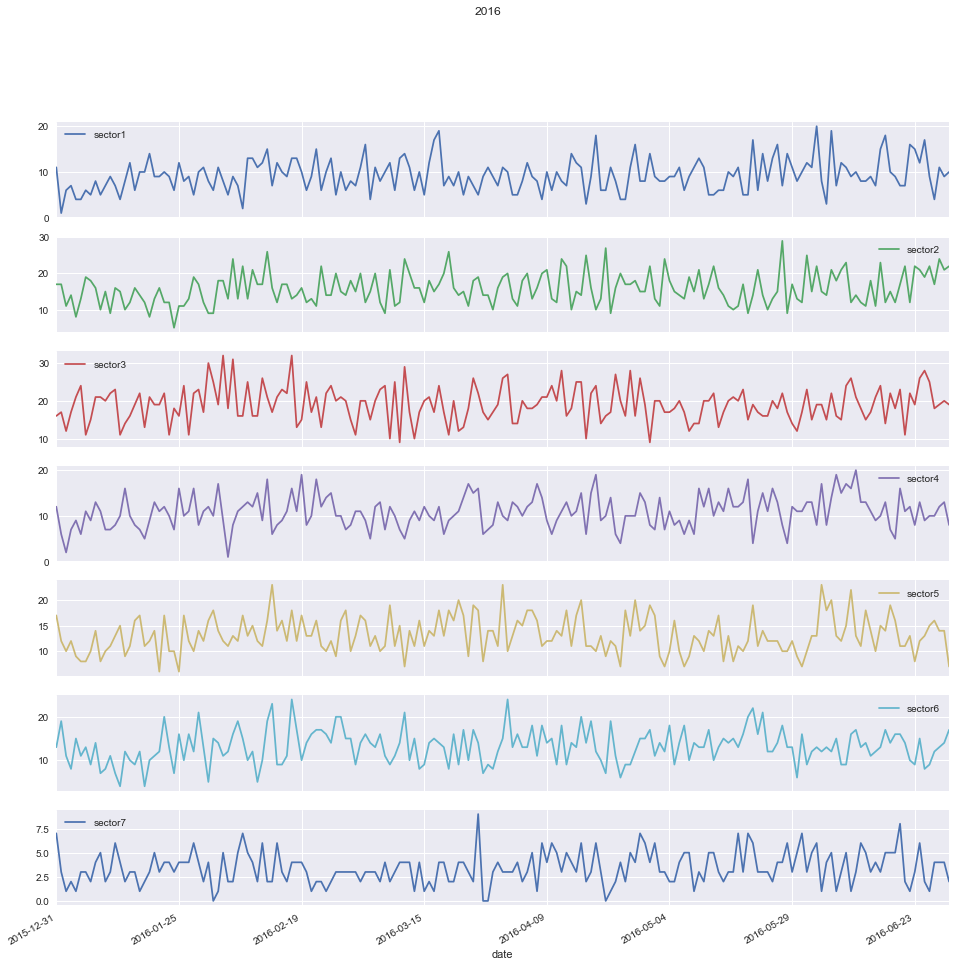

In [120]:
plot_df.iloc[1460:1825].plot(x="date", subplots=True, figsize=(16, 16), title="2016");

### Check Dates
- Check min/max
- Check that the row_count, dates, and diff match by sector

In [121]:
ps.sqldf("""select sector_, count(*) row_count, count(distinct date) dates
,  julianday(max(date)) - julianday(min(date)) + 1 diff, 
 min(date), max(date) 

from df group by 1""", locals())

sector_  row_count  dates    diff   min(date)   max(date)
0        1       1643   1643  1643.0  2012-01-01  2016-06-30
1        2       1643   1643  1643.0  2012-01-01  2016-06-30
2        3       1643   1643  1643.0  2012-01-01  2016-06-30
3        4       1643   1643  1643.0  2012-01-01  2016-06-30
4        5       1643   1643  1643.0  2012-01-01  2016-06-30
5        6       1643   1643  1643.0  2012-01-01  2016-06-30
6        7       1643   1643  1643.0  2012-01-01  2016-06-30

# Machine Learning Section

### Set Index

In [122]:
df=df.set_index(['collision_date','sector'])

In [123]:
df.head()

sector_        date  is_monday  is_tuesday  \
collision_date           sector                                               
2012-01-01T00:00:00.000Z 1.0           1  2012-01-01          0           0   
                         2.0           2  2012-01-01          0           0   
                         3.0           3  2012-01-01          0           0   
                         4.0           4  2012-01-01          0           0   
                         5.0           5  2012-01-01          0           0   

                                 is_wednesday  is_thursday  is_friday  \
collision_date           sector                                         
2012-01-01T00:00:00.000Z 1.0                0            0          0   
                         2.0                0            0          0   
                         3.0                0            0          0   
                         4.0                0            0          0   
                         5.0                0            0          0   

                                 is_saturday  is_sunday  Unnamed: 0  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0               0          1         0.0   
                         2.0               0          1      1720.0   
                         3.0               0          1      3468.0   
                         4.0               0          1      5237.0   
                         5.0               0          1      6962.0   

                                          ...            lighting_B  \
collision_date           sector           ...                         
2012-01-01T00:00:00.000Z 1.0              ...                   1.0   
                         2.0              ...                   0.0   
                         3.0              ...                   1.0   
                         4.0              ...                   1.0   
                         5.0              ...                   0.0   

                                 lighting_C  lighting_D  lighting_E  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0            1.0         0.0         0.0   
                         2.0            9.0         1.0         0.0   
                         3.0           11.0         1.0         0.0   
                         4.0            4.0         0.0         0.0   
                         5.0            8.0         0.0         0.0   

                                 lighting_Unknown  control_device_A  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0                  0.0               1.0   
                         2.0                  0.0               6.0   
                         3.0                  0.0               8.0   
                         4.0                  0.0               3.0   
                         5.0                  0.0               3.0   

                                 control_device_B  control_device_C  \
collision_date           sector                                       
2012-01-01T00:00:00.000Z 1.0                  0.0               0.0   
                         2.0                  0.0               0.0   
                         3.0                  0.0               0.0   
                         4.0                  0.0               0.0   
                         5.0                  0.0               0.0   

                                 control_device_D  control_device_Unknown  
collision_date           sector                                            
2012-01-01T00:00:00.000Z 1.0                  3.0                     0.0  
                         2.0                  8.0                     0.0  
                         3.0                  7.0                     0.0  
                         4.0                  5.0                     0.0  
                     

### DF for each sector

There are seven models, one for each sector.  The 

In [124]:
sector1_df = ps.sqldf("select * from df where sector_ = 1", locals())
sector2_df = ps.sqldf("select * from df where sector_ = 2", locals())
sector3_df = ps.sqldf("select * from df where sector_ = 3", locals())
sector4_df = ps.sqldf("select * from df where sector_ = 4", locals())
sector5_df = ps.sqldf("select * from df where sector_ = 5", locals())
sector6_df = ps.sqldf("select * from df where sector_ = 6", locals())
sector7_df = ps.sqldf("select * from df where sector_ = 7", locals())


In [125]:
dfs = []
dfs.append("")
dfs.append(sector1_df)
dfs.append(sector2_df)
dfs.append(sector3_df)
dfs.append(sector4_df)
dfs.append(sector5_df)
dfs.append(sector6_df)
dfs.append(sector7_df)

In [126]:
for i in range(1, 8):
    dfs[i]=dfs[i].drop(['sector','collision_date', 'Unnamed: 0', 'date', 'sector_'], axis = 1)

In [127]:
for i in range(1, 8):
    print(dfs[i].shape)

(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)
(1643, 120)


### Get collisions_tomorrow

This is used as the target variable.  Shift the data by one.  Drop the row with an na that results from the shift.

In [128]:
for i in range(1, 8):
    dfs[i]['collisions_tomorrow'] = dfs[i]['collisions'].shift(-1)
    dfs[i] = dfs[i].dropna()
 

In [129]:
for i in range(1, 8):
    print(dfs[i].shape)

(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)


In [130]:
for i in range(1, 8):
    print(dfs[i][['collisions', 'collisions_tomorrow']].head())

   collisions  collisions_tomorrow
0         4.0                  6.0
1         6.0                  6.0
2         6.0                  5.0
3         5.0                 13.0
4        13.0                  9.0
   collisions  collisions_tomorrow
0        14.0                  7.0
1         7.0                 16.0
2        16.0                  9.0
3         9.0                 11.0
4        11.0                 14.0
   collisions  collisions_tomorrow
0        15.0                 14.0
1        14.0                 19.0
2        19.0                 15.0
3        15.0                 11.0
4        11.0                 25.0
   collisions  collisions_tomorrow
0         8.0                  8.0
1         8.0                 10.0
2        10.0                  8.0
3         8.0                 11.0
4        11.0                 12.0
   collisions  collisions_tomorrow
0         9.0                 10.0
1        10.0                 11.0
2        11.0                  7.0
3         7.0       

### ACF
- Scroll to see the 7 plots generated

In [131]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

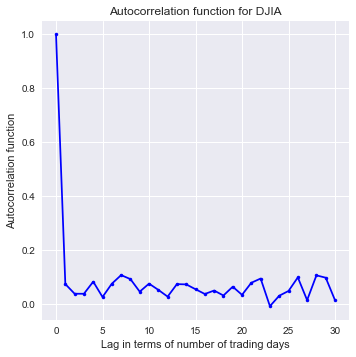

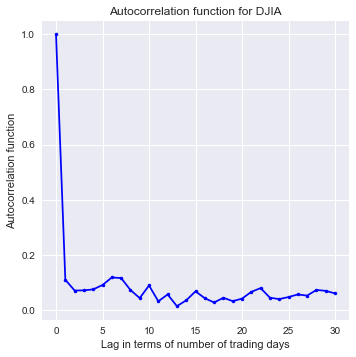

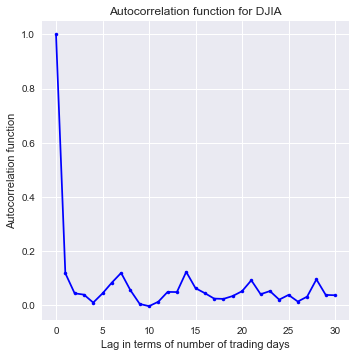

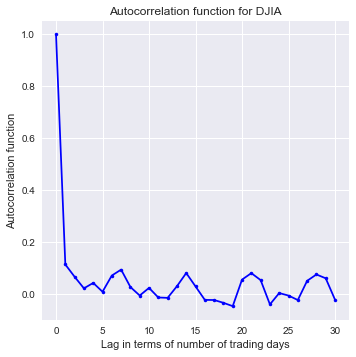

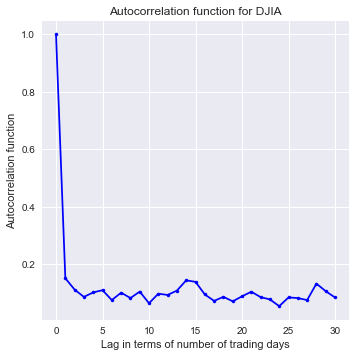

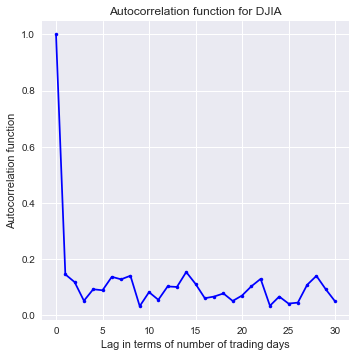

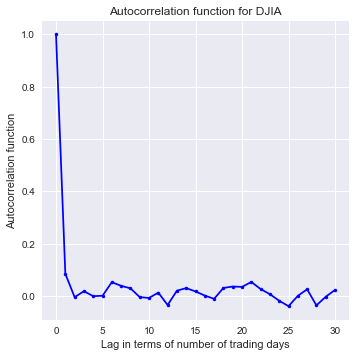

In [132]:
for i in range(1, 8):
    lag = range(0,31)
    df_acf = []
    for l in lag:
        df_acf.append(dfs[i]['collisions_tomorrow'].autocorr(l))
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(df_acf, marker='.', color='b')
    plt.title('Autocorrelation function for DJIA')
    plt.xlabel('Lag in terms of number of trading days')
    plt.ylabel('Autocorrelation function')
    plt.savefig('acf.png', format='png', dpi=300)


Removed because autocorrelation function values are low

In [133]:
# #Plot autocorrelation and confidence intervals using the plot_acf function
# plt.figure(figsize=(5.5, 5.5))
# plot_acf(sector1_df['collisions_tomorrow'], lags=20)
# plt.savefig('acf_ci.png', format='png', dpi=300)

# #Plot autocorrelation and confidence intervals using the plot_acf function
# plt.figure(figsize=(5.5, 5.5))
# plot_pacf(sector1_df['collisions_tomorrow'], lags=20)
# plt.savefig('acf_ci.png', format='png', dpi=300)

##### Observations

- There appears to be no time series correlation, so we can apply regular CV on this dataset.

### Get X and y

In [157]:
print("columns = {}".format(dfs[1].shape[1]))
print(list(dfs[1].columns))

columns = 121
['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'collisions', 'is_12AM_3AM', 'is_3AM_6AM', 'is_6AM_9AM', 'is_9AM_12PM', 'is_12PM_3PM', 'is_3PM_6PM', 'is_6PM_9PM', 'is_9PM_12AM', 'avg_density_per_collision', 'avg_wealth_per_collision', 'avg_intersections_per_collision', 'avg_watts_per_collision', 'avg_lightbulbs_per_collision', 'avg_one_way_signs_per_collision', 'avg_speed_limit_signs_per_collision', 'avg_no_u_turn_signs_per_collision', 'avg_stop_sign_per_collision', 'avg_yield_sign_per_collision', 'high_severity', 'low_severity', 'number_killed', 'number_injured', 'pedestrian_accident', 'bicycle_accident', 'motorcycle_accident', 'truck_accident', 'alcohol_involved', 'count_ped_killed', 'count_ped_injured', 'count_bicyclist_killed', 'count_bicyclist_injured', 'intersection_N', 'intersection_Unknown', 'intersection_Y', 'weather_1_A', 'weather_1_B', 'weather_1_C', 'weather_1_D', 'weather_1_E', 'weather_1_F', 'weather_1_G', 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 0 to 1641
Columns: 121 entries, is_monday to collisions_tomorrow
dtypes: float64(114), int64(7)
memory usage: 1.5 MB


In [134]:
for i in range(1, 8):
    print(dfs[i].shape)

(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)
(1642, 121)


## Split Dataset

In [204]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_trains = [""]
X_tests = [""]
y_trains = [""]
y_tests = [""]

for i in range(1, 8):
    train=dfs[i].sample(frac=0.8,random_state=200)
    test=dfs[i].drop(train.index)
    X_train, y_train, X_test, y_test = train.drop(["collisions_tomorrow"], axis=1), \
    train['collisions_tomorrow'], \
    test.drop(["collisions_tomorrow"], axis=1), \
    test['collisions_tomorrow']

    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    
for i in range(1, 8):
    print(X_trains[i].shape, 
          X_tests[i].shape, 
          y_trains[i].shape, 
          y_tests[i].shape)

(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)
(1314, 120) (328, 120) (1314,) (328,)


In [205]:
#     sector1_df = sector1_df_backup
selected_best_features = []
selected_best_features.append("")

for i in range(1, 8):
    y = y_trains[i]
    X = X_trains[i]
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    select_top_20 = SelectKBest(score_func=chi2, k = 50)
    fit = select_top_20.fit(X,y)
    features = fit.transform(X)
    mask = select_top_20.get_support()
    selected_best_features.append(X.columns[mask])

    from pandas import DataFrame
    from typing import Set, Any
    def remove_others(df: DataFrame, columns: Set[Any]):
        cols_total: Set[Any] = set(df.columns)
        diff: Set[Any] = cols_total - columns
        df.drop(diff, axis=1, inplace=True)
    remove_others(X_trains[i], set(selected_best_features[i]))
    remove_others(X_tests[i], set(selected_best_features[i]))
selected_best_features[1]

Index(['is_thursday', 'is_saturday', 'collisions', 'is_12AM_3AM', 'is_6AM_9AM',
       'is_9AM_12PM', 'is_12PM_3PM', 'is_3PM_6PM', 'is_6PM_9PM',
       'avg_intersections_per_collision', 'avg_watts_per_collision',
       'avg_lightbulbs_per_collision', 'low_severity', 'number_injured',
       'count_ped_injured', 'intersection_N', 'intersection_Y', 'weather_1_A',
       'weather_1_B', 'weather_1_C', 'location_type_N', 'location_type_R',
       'primary_coll_factor_A', 'primary_coll_factor_D',
       'pcf_viol_category_01', 'pcf_viol_category_02', 'pcf_viol_category_03',
       'pcf_viol_category_04', 'pcf_viol_category_07', 'pcf_viol_category_08',
       'pcf_viol_category_09', 'hit_and_run_N', 'type_of_collision_A',
       'type_of_collision_B', 'type_of_collision_C', 'type_of_collision_D',
       'type_of_collision_F', 'type_of_collision_H',
       'type_of_collision_Unknown', 'road_surface_A', 'road_surface_B',
       'road_surface_D', 'road_cond_1_E', 'road_cond_1_H', 'lighting_A',

In [137]:
X_trains[1].shape

(1314, 50)

[  27.94   33.93   38.58   42.69   46.33   49.81   52.9    55.58   57.99
   60.35   62.54   64.72   66.8    68.86   70.84   72.79   74.68   76.56
   78.38   80.18   81.93   83.6    85.24   86.76   88.25   89.67   91.05
   92.4    93.56   94.67   95.69   96.52   97.29   97.96   98.54   98.91
   99.21   99.45   99.62   99.75   99.87   99.92   99.95   99.97   99.99
  100.    100.01  100.01  100.01  100.01]
[ 22.75  29.08  34.37  39.18  43.15  46.41  49.3   52.02  54.57  56.95
  59.23  61.45  63.58  65.67  67.73  69.65  71.54  73.4   75.23  77.02
  78.78  80.52  82.17  83.79  85.36  86.9   88.35  89.69  90.9   92.09
  93.24  94.36  95.39  96.32  97.12  97.88  98.38  98.82  99.2   99.46
  99.68  99.79  99.84  99.89  99.94  99.97  99.99  99.99  99.99  99.99]
[  24.1    30.82   36.9    41.75   45.63   48.76   51.85   54.34   56.78
   59.09   61.34   63.52   65.66   67.74   69.76   71.74   73.71   75.64
   77.52   79.34   81.14   82.89   84.59   86.26   87.89   89.47   90.93
   92.36   93.75  

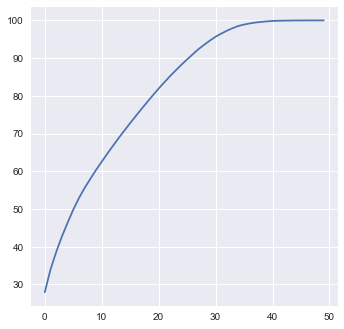

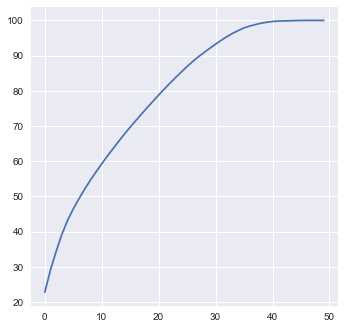

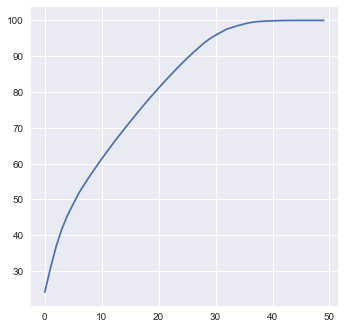

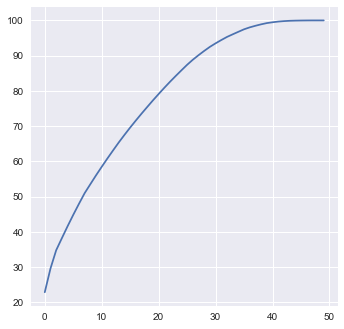

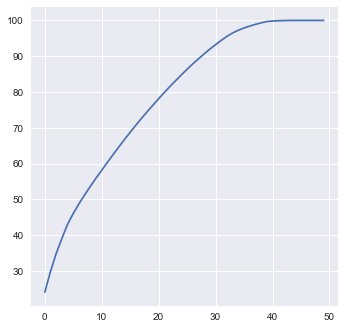

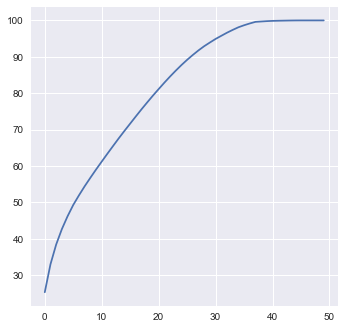

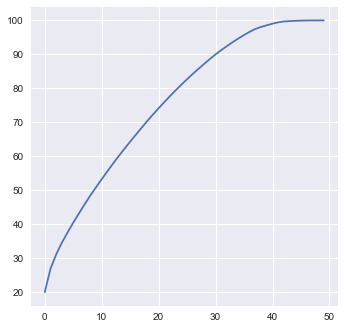

In [138]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

# Holds X for each of the 7 sectors
X_array = []
X_array.append("")
for i in range(1, 8):
    #convert it to numpy arrays
    X = X_trains[i]

    #Scaling the values
    X = scale(X)

    pca = PCA(n_components=50)

    pca.fit(X)

    #The amount of variance that each PC explains
    var= pca.explained_variance_ratio_

    #Cumulative Variance explains
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    print (var1)
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(var1)

    

In [139]:
from sklearn.preprocessing import StandardScaler
PCA_choice = {1: 25, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30} # Based on Graphs
for i in range(1, 8):
    pca = PCA(n_components=PCA_choice[i])
    scaler = StandardScaler()
    X_trains[i] = scaler.fit_transform(X_trains[i])
    X_tests[i] = scaler.transform(X_tests[i])
    X_trains[i] = pca.fit_transform(X_trains[i])
    X_tests[i] = pca.transform(X_tests[i])

In [140]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

baseline_mses = [""]

for i in range(1, 8):
    y_prediction = np.zeros(len(y_tests[i]))
    y_prediction.fill(y_trains[i].mean())

    mse = mean_squared_error(y_tests[i], y_prediction)
    print("Model {}'s baseline mse is {}".format(i, mse))
    baseline_mses.append(mse)

Model 1's baseline mse is 11.881691546581237
Model 2's baseline mse is 18.68284587200452
Model 3's baseline mse is 22.906049681626484
Model 4's baseline mse is 12.273396239571118
Model 5's baseline mse is 12.676493121189424
Model 6's baseline mse is 13.56947358679921
Model 7's baseline mse is 3.181190775544877


In [141]:
print(X_trains[i].shape)
print(y_trains[i].shape)
print(X_tests[i].shape)
print(y_tests[i].shape)

(1314, 30)
(1314,)
(328, 30)
(328,)


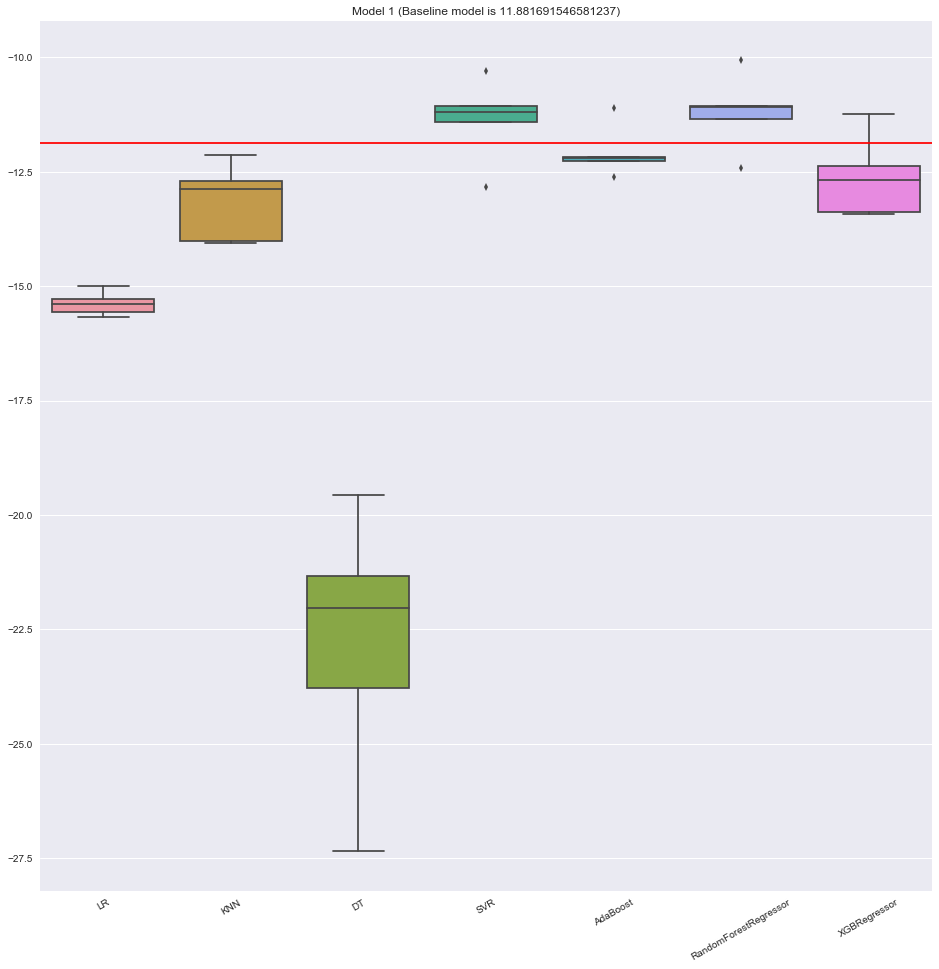

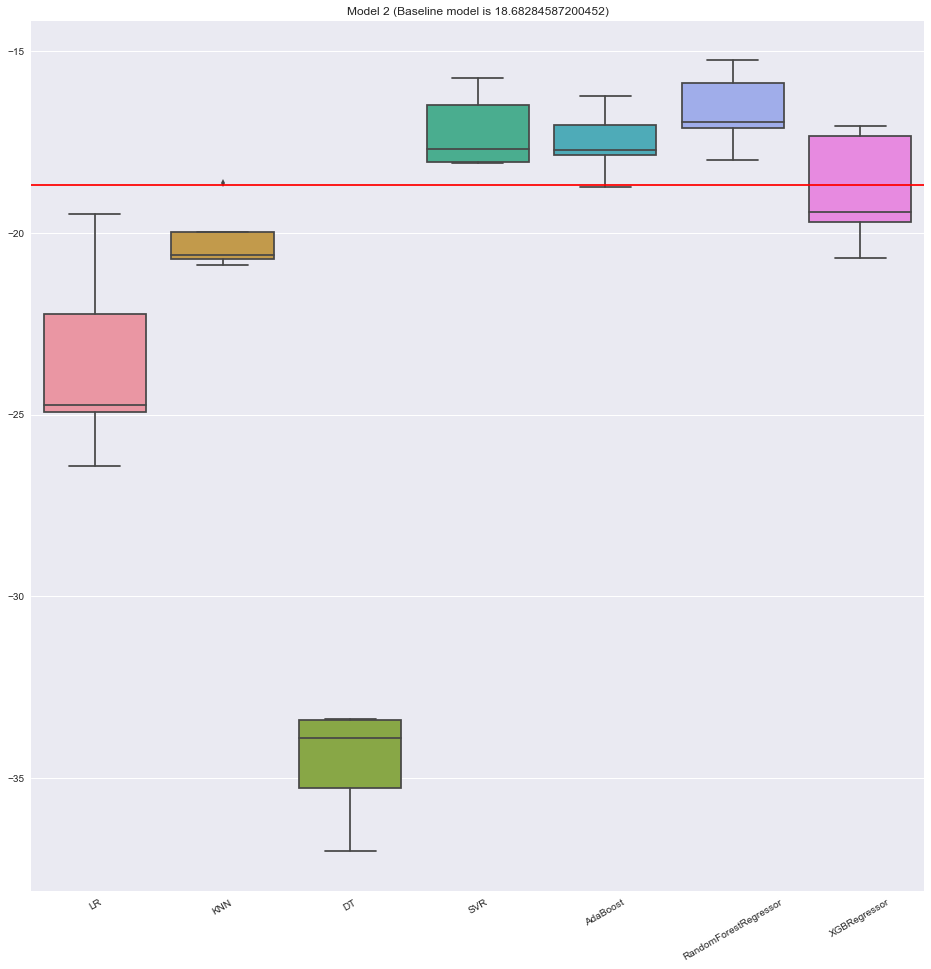

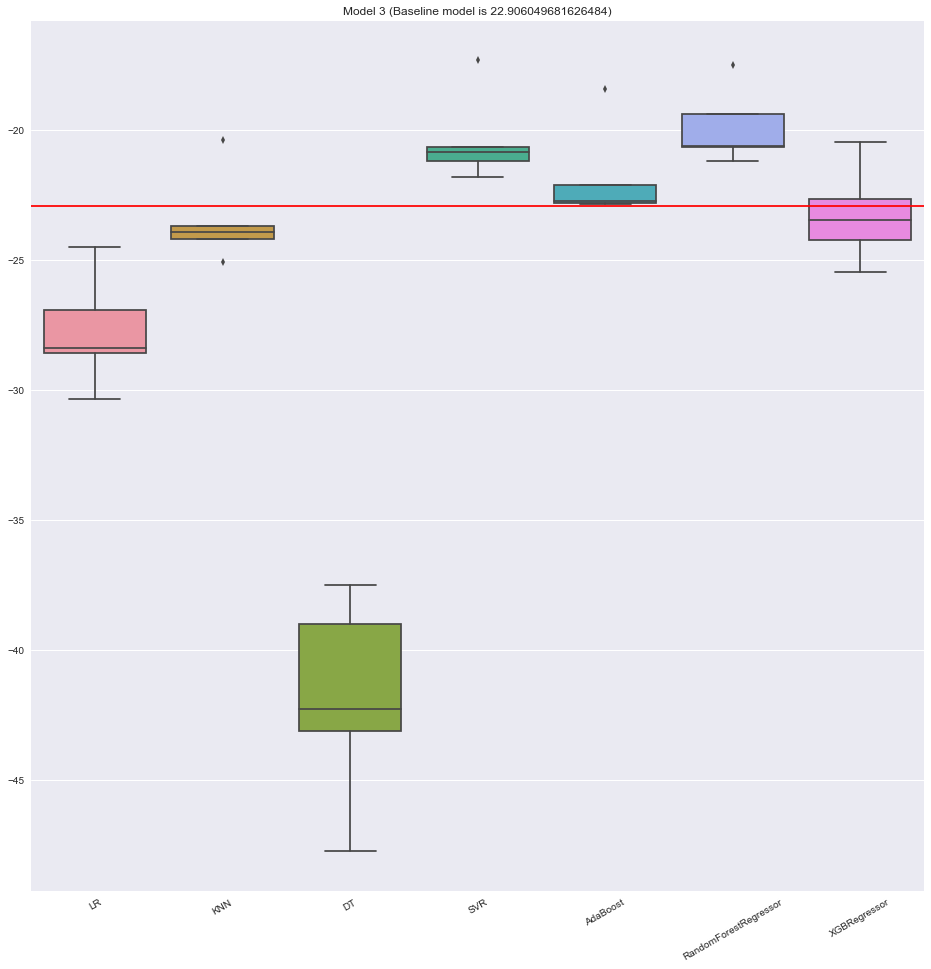

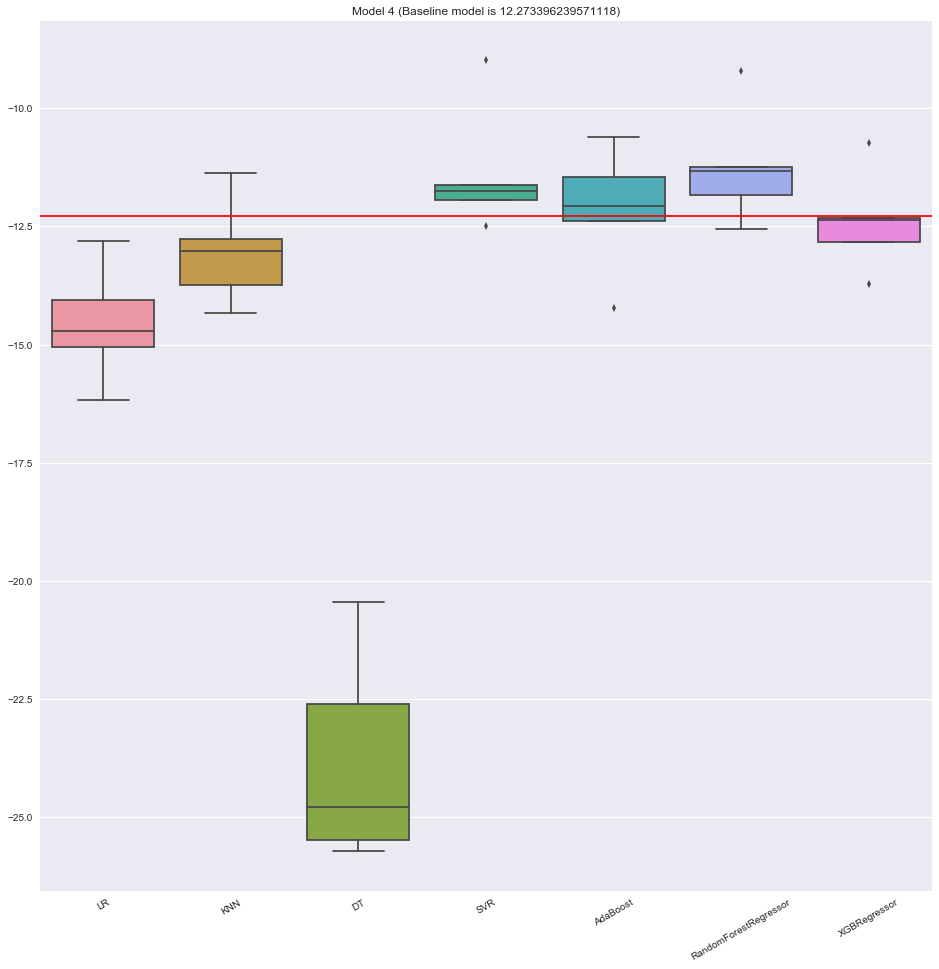

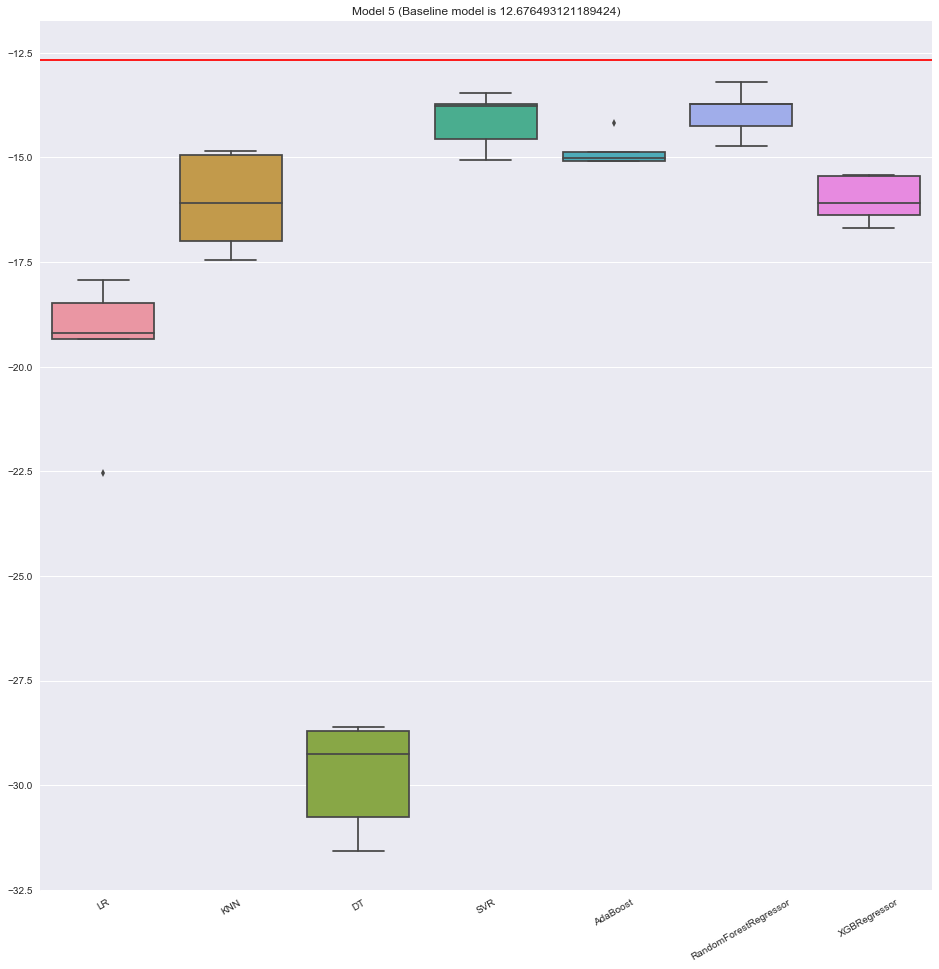

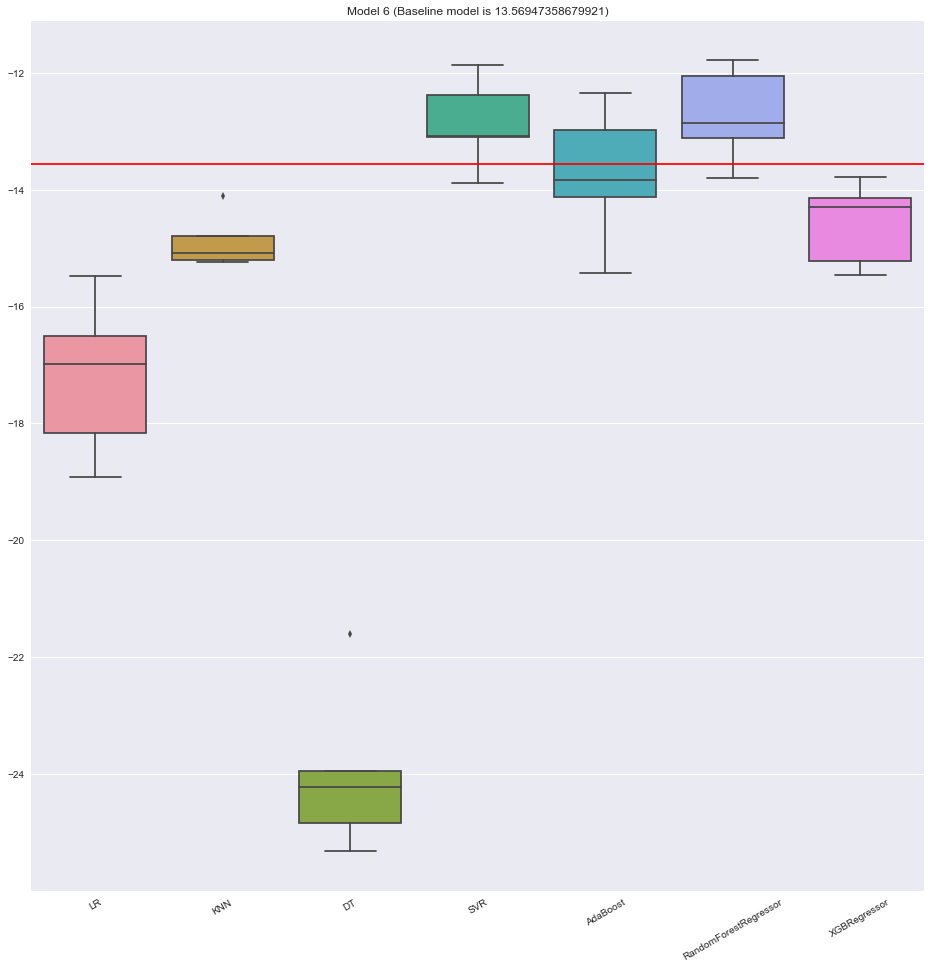

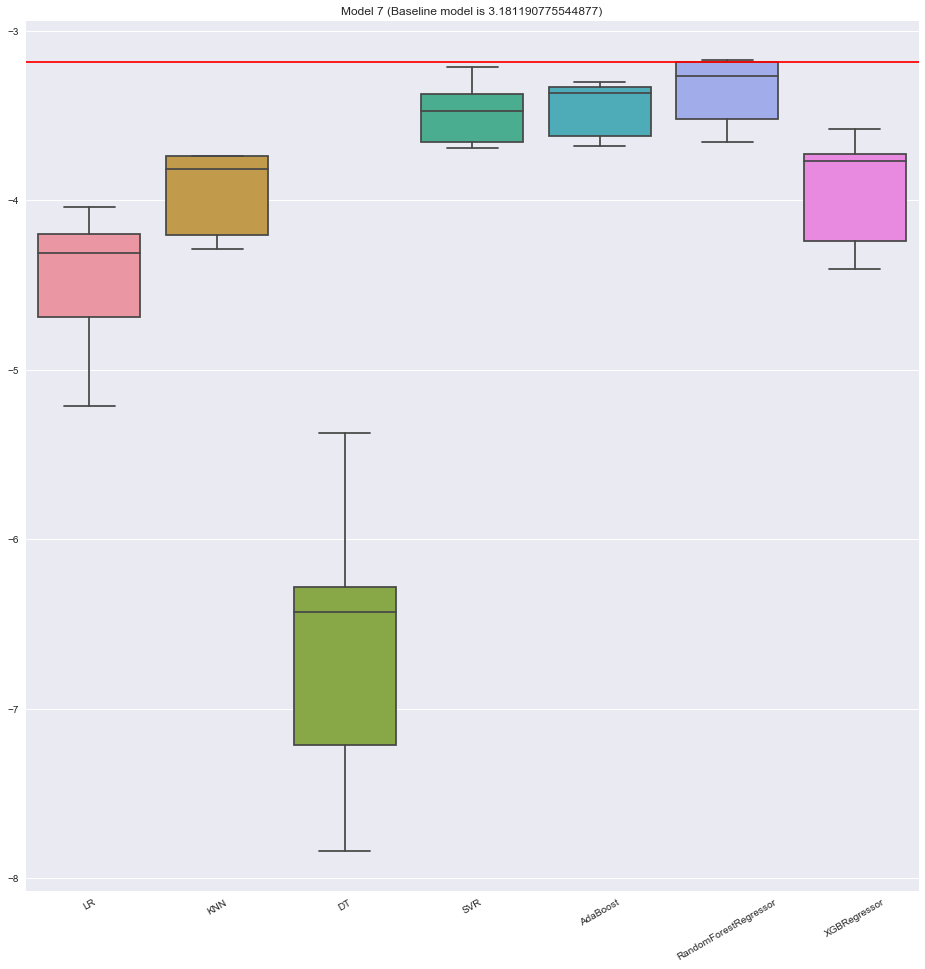

In [89]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

for i in range(1, 8):
    models = []
    models.append(("LR",LogisticRegression()))
    models.append(("KNN",KNeighborsRegressor()))
    models.append(("DT",DecisionTreeRegressor()))
    models.append(("SVR",SVR()))
    models.append(("AdaBoost",AdaBoostRegressor(n_estimators=500, random_state=2)))
    models.append(("RandomForestRegressor",RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
                                            bootstrap = True,random_state=2)))
    models.append(("XGBRegressor",make_pipeline(
        StackingEstimator(estimator=RidgeCV()),
        XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
    )))

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=5, random_state=22)
        cv_result = cross_val_score(model, X_trains[i], y_trains[i], cv = kfold, scoring='neg_mean_squared_error')
        names.append(name)
        results.append(cv_result)
        
#     for i in range(len(names)):
#         print(names[i], results[i].mean())
        
    fig, ax = plt.subplots(figsize=(16, 16))
    ax = sns.boxplot(data=results)
    ax.set_xticklabels(names, rotation=30)
    plt.title("Model {} (Baseline model is {})".format(i, baseline_mses[i]))
    plt.plot(np.linspace(-20,120,1000), [-1*baseline_mses[i]]*1000, 'r')
    plt.savefig('Model_{}_Results.png'.format(i))
    
    
    

### Genetic Algorithm

In [186]:
# for i in range(1, 8):
#     tpot = TPOTRegressor(verbosity=2, max_time_mins=20)
#     tpot.fit(X_trains[i], y_trains[i]) 
#     print(tpot.score(X_tests[i], y_tests[i]))
#     tpot.export('tpot_pipeline_model_{}.py'.format(i))

Optimization Progress: 100%|██████████| 200/200 [01:16<00:00,  3.21pipeline/s]

Generation 1 - Current best internal CV score: -11.411859118294112


Optimization Progress: 100%|██████████| 300/300 [02:17<00:00,  2.20pipeline/s]

Generation 2 - Current best internal CV score: -11.375810096520011


Optimization Progress: 100%|██████████| 400/400 [02:54<00:00,  2.40pipeline/s]

Generation 3 - Current best internal CV score: -11.375810096520011


Optimization Progress: 100%|██████████| 500/500 [03:41<00:00,  2.15pipeline/s]

Generation 4 - Current best internal CV score: -11.368578982606786


Optimization Progress: 100%|██████████| 600/600 [04:30<00:00,  1.84pipeline/s]

Generation 5 - Current best internal CV score: -11.368578982606786


Optimization Progress: 100%|██████████| 700/700 [05:48<00:00,  2.71pipeline/s]

Generation 6 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 800/800 [06:38<00:00,  1.85pipeline/s]

Generation 7 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 900/900 [07:54<00:00,  1.26pipeline/s]

Generation 8 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1000/1000 [08:54<00:00,  1.81pipeline/s]

Generation 9 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1100/1100 [10:02<00:00,  1.45pipeline/s]

Generation 10 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1200/1200 [11:03<00:00,  1.86pipeline/s]

Generation 11 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1300/1300 [12:12<00:00,  2.58pipeline/s]

Generation 12 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1400/1400 [13:19<00:00,  1.97pipeline/s]

Generation 13 - Current best internal CV score: -11.364879130228834


Optimization Progress: 100%|██████████| 1500/1500 [14:22<00:00,  1.72pipeline/s]

Generation 14 - Current best internal CV score: -11.362861571872866


Optimization Progress: 100%|██████████| 1600/1600 [15:29<00:00,  2.09pipeline/s]

Generation 15 - Current best internal CV score: -11.362861571872866


Optimization Progress: 100%|██████████| 1700/1700 [16:40<00:00,  2.31pipeline/s]

Generation 16 - Current best internal CV score: -11.362861571872866


Optimization Progress: 100%|██████████| 1800/1800 [17:49<00:00,  1.60pipeline/s]

Generation 17 - Current best internal CV score: -11.362861571872866


Optimization Progress: 100%|██████████| 1900/1900 [18:54<00:00,  1.47pipeline/s]

Generation 18 - Current best internal CV score: -11.362861571872866



20.011461999999998 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.5, loss=quantile, max_depth=7, max_features=0.45, min_samples_leaf=13, min_samples_split=5, n_estimators=100, subsample=0.15), bootstrap=False, max_features=0.4, min_samples_leaf=18, min_samples_split=20, n_estimators=100)
-11.9153172178


Optimization Progress: 100%|██████████| 200/200 [01:10<00:00,  3.15pipeline/s]

Generation 1 - Current best internal CV score: -16.358213919953826


Optimization Progress: 100%|██████████| 300/300 [01:49<00:00,  3.79pipeline/s]

Generation 2 - Current best internal CV score: -16.358213919953826


Optimization Progress: 100%|██████████| 400/400 [02:18<00:00,  3.94pipeline/s]

Generation 3 - Current best internal CV score: -16.358213919953826


Optimization Progress: 100%|██████████| 500/500 [02:53<00:00,  2.46pipeline/s]

Generation 4 - Current best internal CV score: -16.330088237292948


Optimization Progress: 100%|██████████| 600/600 [03:28<00:00,  3.97pipeline/s]

Generation 5 - Current best internal CV score: -16.330088237292948


Optimization Progress: 100%|██████████| 700/700 [04:01<00:00,  3.14pipeline/s]

Generation 6 - Current best internal CV score: -16.330088237292948


Optimization Progress: 100%|██████████| 800/800 [04:34<00:00,  3.34pipeline/s]

Generation 7 - Current best internal CV score: -16.29440190032078


Optimization Progress: 100%|██████████| 900/900 [05:01<00:00,  3.92pipeline/s]

Generation 8 - Current best internal CV score: -16.29440190032078


Optimization Progress: 100%|██████████| 1000/1000 [05:19<00:00,  6.49pipeline/s]

Generation 9 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1100/1100 [05:47<00:00,  3.50pipeline/s]

Generation 10 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1200/1200 [06:07<00:00,  3.29pipeline/s]

Generation 11 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1300/1300 [06:28<00:00, 10.43pipeline/s]

Generation 12 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1400/1400 [06:34<00:00, 19.28pipeline/s]

Generation 13 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1500/1500 [06:45<00:00,  8.47pipeline/s]

Generation 14 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1600/1600 [06:52<00:00, 22.55pipeline/s]

Generation 15 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1700/1700 [07:11<00:00, 11.31pipeline/s]

Generation 16 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1800/1800 [07:22<00:00, 14.71pipeline/s]

Generation 17 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 1900/1900 [07:31<00:00,  9.47pipeline/s]

Generation 18 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2000/2000 [07:40<00:00, 11.21pipeline/s]

Generation 19 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2100/2100 [08:02<00:00,  2.11pipeline/s]

Generation 20 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2200/2200 [08:13<00:00, 15.32pipeline/s]

Generation 21 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2300/2300 [08:26<00:00,  6.50pipeline/s]

Generation 22 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2400/2400 [08:43<00:00,  4.94pipeline/s]

Generation 23 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2500/2500 [08:55<00:00,  5.56pipeline/s]

Generation 24 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2600/2600 [09:10<00:00,  5.73pipeline/s]

Generation 25 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2700/2700 [09:25<00:00, 11.86pipeline/s]

Generation 26 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2800/2800 [09:36<00:00,  4.33pipeline/s]

Generation 27 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 2900/2900 [10:01<00:00,  6.42pipeline/s]

Generation 28 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3000/3000 [10:20<00:00,  4.00pipeline/s]

Generation 29 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3100/3100 [10:41<00:00,  1.73pipeline/s]

Generation 30 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3200/3200 [11:01<00:00,  6.00pipeline/s]

Generation 31 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3300/3300 [11:18<00:00,  4.44pipeline/s]

Generation 32 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3400/3400 [11:40<00:00,  3.14pipeline/s]

Generation 33 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3500/3500 [12:03<00:00,  7.19pipeline/s]

Generation 34 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3600/3600 [12:26<00:00, 12.18pipeline/s]

Generation 35 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3700/3700 [12:51<00:00,  1.34pipeline/s]

Generation 36 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3800/3800 [13:12<00:00,  6.66pipeline/s]

Generation 37 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 3900/3900 [13:29<00:00,  6.28pipeline/s]

Generation 38 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4000/4000 [13:47<00:00,  2.66pipeline/s]

Generation 39 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4100/4100 [13:57<00:00,  6.45pipeline/s]

Generation 40 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4200/4200 [14:19<00:00,  3.80pipeline/s]

Generation 41 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4300/4300 [14:44<00:00,  8.55pipeline/s]

Generation 42 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4400/4400 [15:03<00:00,  5.41pipeline/s]

Generation 43 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4500/4500 [15:28<00:00,  7.98pipeline/s]

Generation 44 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4600/4600 [15:49<00:00,  8.43pipeline/s]

Generation 45 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4700/4700 [16:19<00:00,  2.16pipeline/s]

Generation 46 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4800/4800 [16:39<00:00,  5.32pipeline/s]

Generation 47 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 4900/4900 [17:08<00:00,  4.18pipeline/s]

Generation 48 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5000/5000 [17:36<00:00,  2.77pipeline/s]

Generation 49 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5100/5100 [17:54<00:00,  9.25pipeline/s]

Generation 50 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5200/5200 [18:14<00:00,  4.96pipeline/s]

Generation 51 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5300/5300 [18:31<00:00,  5.74pipeline/s]

Generation 52 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5400/5400 [18:54<00:00,  4.19pipeline/s]

Generation 53 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5500/5500 [19:20<00:00,  2.53pipeline/s]

Generation 54 - Current best internal CV score: -16.27644301523038


Optimization Progress: 100%|██████████| 5600/5600 [19:40<00:00,  6.21pipeline/s]

Generation 55 - Current best internal CV score: -16.27644301523038



20.026167716666667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(SelectPercentile(input_matrix, percentile=9), learning_rate=0.1, max_depth=1, min_child_weight=2, n_estimators=100, nthread=1, subsample=0.65)
-18.8255995165


Optimization Progress: 100%|██████████| 200/200 [01:43<00:00,  1.44pipeline/s]

Generation 1 - Current best internal CV score: -20.01295606912401


Optimization Progress: 100%|██████████| 300/300 [02:45<00:00,  2.01pipeline/s]

Generation 2 - Current best internal CV score: -20.01295606912401


Optimization Progress: 100%|██████████| 400/400 [03:23<00:00,  1.60pipeline/s]

Generation 3 - Current best internal CV score: -19.940034347283923


Optimization Progress: 100%|██████████| 500/500 [03:58<00:00,  2.69pipeline/s]

Generation 4 - Current best internal CV score: -19.940034347283923


Optimization Progress: 100%|██████████| 600/600 [04:33<00:00,  2.14pipeline/s]

Generation 5 - Current best internal CV score: -19.940034347283923


Optimization Progress: 100%|██████████| 700/700 [05:05<00:00,  4.32pipeline/s]

Generation 6 - Current best internal CV score: -19.940034347283923


Optimization Progress: 100%|██████████| 800/800 [05:34<00:00,  4.35pipeline/s]

Generation 7 - Current best internal CV score: -19.91460053129732


Optimization Progress: 100%|██████████| 900/900 [05:58<00:00,  8.39pipeline/s]

Generation 8 - Current best internal CV score: -19.914582536745023


Optimization Progress: 100%|██████████| 1000/1000 [06:28<00:00,  3.16pipeline/s]

Generation 9 - Current best internal CV score: -19.914582536745023


Optimization Progress: 100%|██████████| 1100/1100 [06:54<00:00,  4.93pipeline/s]

Generation 10 - Current best internal CV score: -19.914582536745023


Optimization Progress: 100%|██████████| 1200/1200 [07:13<00:00, 10.15pipeline/s]

Generation 11 - Current best internal CV score: -19.914582536745023


Optimization Progress: 100%|██████████| 1300/1300 [07:31<00:00,  7.38pipeline/s]

Generation 12 - Current best internal CV score: -19.914582536745023


Optimization Progress: 100%|██████████| 1400/1400 [07:55<00:00,  4.36pipeline/s]

Generation 13 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 1500/1500 [08:21<00:00,  3.10pipeline/s]

Generation 14 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 1600/1600 [08:41<00:00,  5.88pipeline/s]

Generation 15 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 1700/1700 [09:10<00:00,  3.26pipeline/s]

Generation 16 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 1800/1800 [09:40<00:00,  3.08pipeline/s]

Generation 17 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 1900/1900 [10:04<00:00,  5.35pipeline/s]

Generation 18 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2000/2000 [10:33<00:00,  4.15pipeline/s]

Generation 19 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2100/2100 [11:00<00:00,  6.07pipeline/s]

Generation 20 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2200/2200 [11:27<00:00,  8.32pipeline/s]

Generation 21 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2300/2300 [11:53<00:00,  8.08pipeline/s]

Generation 22 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2400/2400 [12:19<00:00,  1.01pipeline/s]

Generation 23 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2500/2500 [12:50<00:00,  2.01pipeline/s]

Generation 24 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2600/2600 [13:12<00:00,  2.98pipeline/s]

Generation 25 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2700/2700 [13:37<00:00,  9.82pipeline/s]

Generation 26 - Current best internal CV score: -19.89282172548747


Optimization Progress: 100%|██████████| 2800/2800 [14:07<00:00,  3.91pipeline/s]

Generation 27 - Current best internal CV score: -19.880122596331407


Optimization Progress: 100%|██████████| 2900/2900 [14:35<00:00,  2.10pipeline/s]

Generation 28 - Current best internal CV score: -19.88010618630671


Optimization Progress: 100%|██████████| 3000/3000 [14:57<00:00,  8.08pipeline/s]

Generation 29 - Current best internal CV score: -19.88004709937085


Optimization Progress: 100%|██████████| 3100/3100 [15:24<00:00,  8.37pipeline/s]

Generation 30 - Current best internal CV score: -19.88004709937085


Optimization Progress: 100%|██████████| 3200/3200 [15:55<00:00,  3.37pipeline/s]

Generation 31 - Current best internal CV score: -19.88004709937085


Optimization Progress: 100%|██████████| 3300/3300 [16:23<00:00,  3.14pipeline/s]

Generation 32 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3400/3400 [16:48<00:00,  5.53pipeline/s]

Generation 33 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3500/3500 [17:13<00:00,  3.96pipeline/s]

Generation 34 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3600/3600 [17:44<00:00,  4.46pipeline/s]

Generation 35 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3700/3700 [18:08<00:00,  4.84pipeline/s]

Generation 36 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3800/3800 [18:30<00:00,  7.15pipeline/s]

Generation 37 - Current best internal CV score: -19.87986369510931


Optimization Progress: 100%|██████████| 3900/3900 [18:56<00:00,  7.16pipeline/s]

Generation 38 - Current best internal CV score: -19.85766188544193


Optimization Progress: 100%|██████████| 4000/4000 [19:23<00:00,  4.13pipeline/s]

Generation 39 - Current best internal CV score: -19.85766188544193


Optimization Progress: 100%|██████████| 4100/4100 [19:46<00:00,  4.72pipeline/s]

Generation 40 - Current best internal CV score: -19.85766188544193



20.002640383333336 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(FastICA(RidgeCV(LassoLarsCV(SelectFwe(input_matrix, alpha=0.002), normalize=False)), tol=0.85), normalize=False)
-22.6580145628


Optimization Progress: 100%|██████████| 200/200 [01:37<00:00,  2.96pipeline/s]

Generation 1 - Current best internal CV score: -11.577396443412525


Optimization Progress: 100%|██████████| 300/300 [02:11<00:00,  3.41pipeline/s]

Generation 2 - Current best internal CV score: -11.54229658416578


Optimization Progress: 100%|██████████| 400/400 [02:50<00:00,  2.48pipeline/s]

Generation 3 - Current best internal CV score: -11.54229658416578


Optimization Progress: 100%|██████████| 500/500 [03:34<00:00,  2.36pipeline/s]

Generation 4 - Current best internal CV score: -11.541518014486712


Optimization Progress: 100%|██████████| 600/600 [04:19<00:00,  2.93pipeline/s]

Generation 5 - Current best internal CV score: -11.541518014486712


Optimization Progress: 100%|██████████| 700/700 [05:02<00:00,  3.32pipeline/s]

Generation 6 - Current best internal CV score: -11.541336729320738


Optimization Progress: 100%|██████████| 800/800 [05:38<00:00,  3.61pipeline/s]

Generation 7 - Current best internal CV score: -11.541336729320738


Optimization Progress: 100%|██████████| 900/900 [06:16<00:00,  4.74pipeline/s]

Generation 8 - Current best internal CV score: -11.541336729320738


Optimization Progress: 100%|██████████| 1000/1000 [06:46<00:00,  3.20pipeline/s]

Generation 9 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1100/1100 [07:16<00:00,  4.39pipeline/s]

Generation 10 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1200/1200 [07:46<00:00,  3.58pipeline/s]

Generation 11 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1300/1300 [08:19<00:00,  2.40pipeline/s]

Generation 12 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1400/1400 [08:47<00:00,  2.31pipeline/s]

Generation 13 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1500/1500 [09:13<00:00,  3.28pipeline/s]

Generation 14 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1600/1600 [09:39<00:00,  3.60pipeline/s]

Generation 15 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1700/1700 [10:08<00:00,  1.99pipeline/s]

Generation 16 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1800/1800 [10:42<00:00,  3.04pipeline/s]

Generation 17 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 1900/1900 [11:14<00:00,  4.73pipeline/s]

Generation 18 - Current best internal CV score: -11.52827598024341


Optimization Progress: 100%|██████████| 2000/2000 [12:07<00:00,  2.17pipeline/s]

Generation 19 - Current best internal CV score: -11.52484568942203


Optimization Progress: 100%|██████████| 2100/2100 [13:06<00:00,  2.18pipeline/s]

Generation 20 - Current best internal CV score: -11.52484568942203


Optimization Progress: 100%|██████████| 2200/2200 [14:06<00:00,  1.60pipeline/s]

Generation 21 - Current best internal CV score: -11.521030082824405


Optimization Progress: 100%|██████████| 2300/2300 [15:08<00:00,  2.64pipeline/s]

Generation 22 - Current best internal CV score: -11.521030082824405


Optimization Progress: 100%|██████████| 2400/2400 [16:08<00:00,  1.89pipeline/s]

Generation 23 - Current best internal CV score: -11.501392819468307


Optimization Progress: 100%|██████████| 2500/2500 [17:10<00:00,  1.81pipeline/s]

Generation 24 - Current best internal CV score: -11.501392819468307


Optimization Progress: 100%|██████████| 2600/2600 [18:03<00:00,  1.56pipeline/s]

Generation 25 - Current best internal CV score: -11.501392819468307


Optimization Progress: 100%|██████████| 2700/2700 [19:01<00:00,  1.97pipeline/s]

Generation 26 - Current best internal CV score: -11.501392819468307



20.002528716666667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(SelectFwe(input_matrix, alpha=0.036), bootstrap=True, max_features=0.4, min_samples_leaf=4, min_samples_split=12, n_estimators=100)
-12.3696972272


Optimization Progress: 100%|██████████| 200/200 [01:28<00:00,  2.76pipeline/s]

Generation 1 - Current best internal CV score: -13.713590367864407


Optimization Progress: 100%|██████████| 300/300 [02:13<00:00,  2.94pipeline/s]

Generation 2 - Current best internal CV score: -13.713221907041746


Optimization Progress: 100%|██████████| 400/400 [02:38<00:00,  1.81pipeline/s]

Generation 3 - Current best internal CV score: -13.713221907041746


Optimization Progress: 100%|██████████| 500/500 [02:58<00:00,  5.18pipeline/s]

Generation 4 - Current best internal CV score: -13.713221907041746


Optimization Progress: 100%|██████████| 600/600 [03:20<00:00,  5.90pipeline/s]

Generation 5 - Current best internal CV score: -13.709677912493003


Optimization Progress: 100%|██████████| 700/700 [03:46<00:00,  6.49pipeline/s]

Generation 6 - Current best internal CV score: -13.709677912493003


Optimization Progress: 100%|██████████| 800/800 [04:05<00:00,  6.18pipeline/s]

Generation 7 - Current best internal CV score: -13.709677912493003


Optimization Progress: 100%|██████████| 900/900 [04:23<00:00, 10.08pipeline/s]

Generation 8 - Current best internal CV score: -13.709677912493003


Optimization Progress: 100%|██████████| 1000/1000 [04:46<00:00,  3.17pipeline/s]

Generation 9 - Current best internal CV score: -13.701087693299304


Optimization Progress: 100%|██████████| 1100/1100 [05:04<00:00,  7.53pipeline/s]

Generation 10 - Current best internal CV score: -13.701087693299304


Optimization Progress: 100%|██████████| 1200/1200 [05:26<00:00,  9.01pipeline/s]

Generation 11 - Current best internal CV score: -13.701087693299304


Optimization Progress: 100%|██████████| 1300/1300 [05:46<00:00,  5.26pipeline/s]

Generation 12 - Current best internal CV score: -13.701087693299304


Optimization Progress: 100%|██████████| 1400/1400 [06:03<00:00,  7.00pipeline/s]

Generation 13 - Current best internal CV score: -13.701087693299304


Optimization Progress: 100%|██████████| 1500/1500 [06:14<00:00, 14.95pipeline/s]

Generation 14 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 1600/1600 [06:40<00:00, 11.20pipeline/s]

Generation 15 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 1700/1700 [06:52<00:00,  6.47pipeline/s]

Generation 16 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 1800/1800 [07:16<00:00,  1.36pipeline/s]

Generation 17 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 1900/1900 [07:31<00:00,  7.74pipeline/s]

Generation 18 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2000/2000 [07:52<00:00,  4.70pipeline/s]

Generation 19 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2100/2100 [08:07<00:00, 16.23pipeline/s]

Generation 20 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2200/2200 [08:21<00:00,  4.92pipeline/s]

Generation 21 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2300/2300 [08:36<00:00,  7.72pipeline/s]

Generation 22 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2400/2400 [08:47<00:00,  7.93pipeline/s]

Generation 23 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2500/2500 [09:05<00:00, 10.94pipeline/s]

Generation 24 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2600/2600 [09:21<00:00,  6.86pipeline/s]

Generation 25 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2700/2700 [09:44<00:00,  5.25pipeline/s]

Generation 26 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2800/2800 [10:04<00:00,  2.60pipeline/s]

Generation 27 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 2900/2900 [10:16<00:00,  8.25pipeline/s]

Generation 28 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3000/3000 [10:31<00:00,  7.08pipeline/s]

Generation 29 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3100/3100 [10:52<00:00,  5.47pipeline/s]

Generation 30 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3200/3200 [11:13<00:00,  9.51pipeline/s]

Generation 31 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3300/3300 [11:37<00:00,  6.65pipeline/s]

Generation 32 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3400/3400 [12:01<00:00,  5.32pipeline/s]

Generation 33 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3500/3500 [12:14<00:00, 15.42pipeline/s]

Generation 34 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3600/3600 [12:28<00:00,  4.24pipeline/s]

Generation 35 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3700/3700 [12:49<00:00,  2.51pipeline/s]

Generation 36 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3800/3800 [13:20<00:00,  3.63pipeline/s]

Generation 37 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 3900/3900 [13:38<00:00,  8.18pipeline/s]

Generation 38 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4000/4000 [14:01<00:00,  5.21pipeline/s]

Generation 39 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4100/4100 [14:19<00:00,  6.31pipeline/s]

Generation 40 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4200/4200 [14:43<00:00,  3.19pipeline/s]

Generation 41 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4300/4300 [15:14<00:00,  4.41pipeline/s]

Generation 42 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4400/4400 [15:40<00:00,  5.89pipeline/s]

Generation 43 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4500/4500 [16:10<00:00,  5.12pipeline/s]

Generation 44 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4600/4600 [16:36<00:00,  5.42pipeline/s]

Generation 45 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4700/4700 [17:23<00:00,  6.71pipeline/s]

Generation 46 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4800/4800 [17:56<00:00,  4.90pipeline/s]

Generation 47 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 4900/4900 [18:29<00:00,  3.17pipeline/s]

Generation 48 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 5000/5000 [19:04<00:00,  3.44pipeline/s]

Generation 49 - Current best internal CV score: -13.691069703936401


Optimization Progress: 100%|██████████| 5100/5100 [19:36<00:00,  5.51pipeline/s]

Generation 50 - Current best internal CV score: -13.691069703936401



20.00736991666667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(ElasticNetCV(SelectFwe(input_matrix, alpha=0.009), l1_ratio=0.65, tol=0.0001), normalize=True)
-12.3808870576


Optimization Progress: 100%|██████████| 200/200 [01:36<00:00,  1.45pipeline/s]

Generation 1 - Current best internal CV score: -13.027481043840842


Optimization Progress: 100%|██████████| 300/300 [02:16<00:00,  2.35pipeline/s]

Generation 2 - Current best internal CV score: -13.027108608671565


Optimization Progress: 100%|██████████| 400/400 [02:54<00:00,  1.10s/pipeline]

Generation 3 - Current best internal CV score: -13.027108608671565


Optimization Progress: 100%|██████████| 500/500 [03:45<00:00,  3.19pipeline/s]

Generation 4 - Current best internal CV score: -13.027108608671565


Optimization Progress: 100%|██████████| 600/600 [04:23<00:00,  3.84pipeline/s]

Generation 5 - Current best internal CV score: -13.027108608671565


Optimization Progress: 100%|██████████| 700/700 [04:52<00:00,  5.00pipeline/s]

Generation 6 - Current best internal CV score: -13.026868579816181


Optimization Progress: 100%|██████████| 800/800 [05:12<00:00,  6.82pipeline/s]

Generation 7 - Current best internal CV score: -13.026868579816181


Optimization Progress: 100%|██████████| 900/900 [05:45<00:00,  3.77pipeline/s]

Generation 8 - Current best internal CV score: -13.02289926220864


Optimization Progress: 100%|██████████| 1000/1000 [06:02<00:00,  7.97pipeline/s]

Generation 9 - Current best internal CV score: -13.02289926220864


Optimization Progress: 100%|██████████| 1100/1100 [06:14<00:00,  6.89pipeline/s]

Generation 10 - Current best internal CV score: -13.02289926220864


Optimization Progress: 100%|██████████| 1200/1200 [06:29<00:00,  7.73pipeline/s]

Generation 11 - Current best internal CV score: -13.02289926220864


Optimization Progress: 100%|██████████| 1300/1300 [06:45<00:00,  6.97pipeline/s]

Generation 12 - Current best internal CV score: -13.02289926220864


Optimization Progress: 100%|██████████| 1400/1400 [06:56<00:00, 14.05pipeline/s]

Generation 13 - Current best internal CV score: -13.019222249446017


Optimization Progress: 100%|██████████| 1500/1500 [07:14<00:00,  2.90pipeline/s]

Generation 14 - Current best internal CV score: -13.019222249446017


Optimization Progress: 100%|██████████| 1600/1600 [07:34<00:00,  3.50pipeline/s]

Generation 15 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 1700/1700 [07:55<00:00,  5.46pipeline/s]

Generation 16 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 1800/1800 [08:15<00:00,  4.59pipeline/s]

Generation 17 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 1900/1900 [08:31<00:00,  6.12pipeline/s]

Generation 18 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 2000/2000 [08:50<00:00,  6.71pipeline/s]

Generation 19 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 2100/2100 [09:03<00:00,  5.86pipeline/s]

Generation 20 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 2200/2200 [09:18<00:00,  4.04pipeline/s]

Generation 21 - Current best internal CV score: -13.00113943217336


Optimization Progress: 100%|██████████| 2300/2300 [09:37<00:00,  7.46pipeline/s]

Generation 22 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2400/2400 [09:54<00:00,  7.43pipeline/s]

Generation 23 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2500/2500 [10:11<00:00,  2.16pipeline/s]

Generation 24 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2600/2600 [10:31<00:00,  8.56pipeline/s]

Generation 25 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2700/2700 [10:51<00:00,  4.39pipeline/s]

Generation 26 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2800/2800 [11:11<00:00,  5.40pipeline/s]

Generation 27 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 2900/2900 [11:22<00:00, 11.30pipeline/s]

Generation 28 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3000/3000 [11:36<00:00,  7.71pipeline/s]

Generation 29 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3100/3100 [11:55<00:00,  4.00pipeline/s]

Generation 30 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3200/3200 [12:08<00:00,  9.75pipeline/s]

Generation 31 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3300/3300 [12:26<00:00,  8.99pipeline/s]

Generation 32 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3400/3400 [12:54<00:00,  4.15pipeline/s]

Generation 33 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3500/3500 [13:10<00:00,  2.30pipeline/s]

Generation 34 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3600/3600 [13:30<00:00,  4.61pipeline/s]

Generation 35 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3700/3700 [13:52<00:00,  3.50pipeline/s]

Generation 36 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3800/3800 [14:09<00:00,  4.23pipeline/s]

Generation 37 - Current best internal CV score: -12.99520479385628


Optimization Progress: 100%|██████████| 3900/3900 [14:28<00:00,  3.95pipeline/s]

Generation 38 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4000/4000 [14:47<00:00,  5.21pipeline/s]

Generation 39 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4100/4100 [15:05<00:00,  4.76pipeline/s]

Generation 40 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4200/4200 [15:24<00:00,  1.93pipeline/s]

Generation 41 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4300/4300 [15:47<00:00,  5.88pipeline/s]

Generation 42 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4400/4400 [16:04<00:00,  5.64pipeline/s]

Generation 43 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4500/4500 [16:23<00:00,  3.57pipeline/s]

Generation 44 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4600/4600 [16:44<00:00,  4.52pipeline/s]

Generation 45 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4700/4700 [17:12<00:00,  7.91pipeline/s]

Generation 46 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4800/4800 [17:36<00:00,  4.41pipeline/s]

Generation 47 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 4900/4900 [17:55<00:00,  9.12pipeline/s]

Generation 48 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 5000/5000 [18:20<00:00,  3.64pipeline/s]

Generation 49 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 5100/5100 [18:44<00:00,  2.43pipeline/s]

Generation 50 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 5200/5200 [19:05<00:00,  4.66pipeline/s]

Generation 51 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 5300/5300 [19:24<00:00, 12.91pipeline/s]

Generation 52 - Current best internal CV score: -12.977033757883095


Optimization Progress: 100%|██████████| 5400/5400 [19:37<00:00,  8.20pipeline/s]

Generation 53 - Current best internal CV score: -12.975512437874437


Optimization Progress: 100%|██████████| 5500/5500 [19:53<00:00,  9.04pipeline/s]

Generation 54 - Current best internal CV score: -12.975512437874437



20.0005807 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(LassoLarsCV(SelectFwe(RobustScaler(StandardScaler(input_matrix)), alpha=0.026), normalize=False), normalize=True)
-13.1187842084


Optimization Progress: 100%|██████████| 200/200 [01:54<00:00,  1.16pipeline/s]

Generation 1 - Current best internal CV score: -3.2705110523701437


Optimization Progress: 100%|██████████| 300/300 [02:53<00:00,  2.45pipeline/s]

Generation 2 - Current best internal CV score: -3.2705110523701437




TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(Binarizer(input_matrix, threshold=0.45), normalize=False)
-3.16382883018


## TODO

- Do feature importance

## Build the Final Models

##### Sector 1 - SVR

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_svr = Pipeline([('clf', SVR())])
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
epsilon_range = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
param_grid = [{'clf__C': param_range,
               'clf__epsilon': epsilon_range,
              'clf__kernel': ['linear']
              },
              {'clf__C': param_range,
               'clf__epsilon': epsilon_range,               
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']
              }
             ]
gs = GridSearchCV(estimator=pipe_svr,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[1], y_trains[1])
print(gs.best_score_)
print(gs.best_params_)
                  

-11.069830834358319
{'clf__C': 25.0, 'clf__epsilon': 1.0, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}


In [165]:
from sklearn.metrics import mean_squared_error
final_model1 = SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf')
final_model1.fit(X_trains[1],y_trains[1],sample_weight=None)
y_predict = final_model1.predict(X_tests[1])
mse = mean_squared_error(y_tests[1], y_predict)
print(-1*mse)

-11.7726332199


In [179]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
boston = load_boston()
np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()



array([3, 8])

In [184]:
boston

{'data': array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  6.07600000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   5.64000000e+00],
       [  1.09590000e-01,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.93450000e+02,   6.48000000e+00],
       [  4.74100000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   7.88000000e+00]]), 'target': array([ 24. ,  21.6,  34.7,  33.4,  36.2,  28.7,  22.9,  27.1,  16.5,
        18.9,  15. ,  18.9,  21.7,  20.4,  18.2,  19.9,  23.1,  17.5,
        20.2,  18.2,  13.6,  19.6,  15.2,  14.

In [ ]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()


In [248]:
X_tests[1]

is_thursday  is_saturday  collisions  is_12AM_3AM  is_6AM_9AM  \
0               0            0         4.0          1.0         0.0   
10              0            0        10.0          1.0         2.0   
15              0            0         6.0          0.0         0.0   
17              0            0        10.0          0.0         5.0   
18              1            0        13.0          0.0         5.0   
27              0            1         3.0          0.0         0.0   
29              0            0         9.0          0.0         1.0   
52              0            0        11.0          0.0         2.0   
55              0            1         9.0          2.0         0.0   
67              1            0         5.0          2.0         0.0   
73              0            0        12.0          1.0         2.0   
76              0            1        20.0          1.0         0.0   
81              1            0        10.0          1.0         1.0   
84              0            0        11.0          4.0         1.0   
85              0            0         8.0          1.0         2.0   
89              0            0         4.0          0.0         0.0   
90              0            1         9.0          1.0         0.0   
91              0            0         5.0          1.0         1.0   
93              0            0         4.0          0.0         0.0   
94              0            0         6.0          0.0         0.0   
97              0            1         8.0          0.0         1.0   
98              0            0         6.0          1.0         0.0   
100             0            0         8.0          0.0         2.0   
102             1            0        12.0          1.0         2.0   
104             0            1         5.0          1.0         0.0   
106             0            0         8.0          1.0         0.0   
111             0            1        13.0          1.0         2.0   
128             0            0         8.0          0.0         0.0   
137             1            0         4.0          1.0         3.0   
139             0            1        16.0          2.0         1.0   
...           ...          ...         ...          ...         ...   
1478            0            0        10.0          0.0         0.0   
1487            0            0         9.0          0.0         5.0   
1495            1            0         5.0          0.0         2.0   
1501            0            0        11.0          1.0         3.0   
1502            1            0        12.0          0.0         2.0   
1513            0            0        15.0          1.0         4.0   
1522            0            0        11.0          0.0         0.0   
1526            0            0         8.0          3.0         0.0   
1530            1            0        13.0          1.0         0.0   
1537            1            0        17.0          0.0         3.0   
1539            0            1         7.0          1.0         1.0   
1543            0            0         5.0          0.0         1.0   
1544            1            0         9.0          0.0         0.0   
1546            0            1         5.0          1.0         0.0   
1564            0            0         7.0          0.0         2.0   
1566            0            0        12.0          0.0         2.0   
1580            0            0         8.0          0.0         1.0   
1584            0            0         8.0          1.0         0.0   
1592            0            0        11.0          0.0         2.0   
1595            0            1         6.0          1.0         0.0   
1600            1            0         5.0          0.0         0.0   
1603            0            0         6.0          2.0         0.0   
1604            0            0        14.0          0.0         2.0   
1608            0            0         7.0          1.0         1.0   
1609            0            1

In [254]:
exp.show_in_notebook()

In [213]:
#     sector1_df = sector1_df_backup
selected_best_features = []
selected_best_features.append("")

X = train.drop(["collisions_tomorrow"], axis=1)
y = train['collisions_tomorrow']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_top_20 = SelectKBest(score_func=chi2, k = 50)
fit = select_top_20.fit(X,y)
features = fit.transform(X)
mask = select_top_20.get_support()
selected_best_features = X.columns[mask]

from pandas import DataFrame
from typing import Set, Any
def remove_others(df: DataFrame, columns: Set[Any]):
    cols_total: Set[Any] = set(df.columns)
    diff: Set[Any] = cols_total - columns
    df.drop(diff, axis=1, inplace=True)
remove_others(X, set(selected_best_features))
selected_best_features

Index(['is_thursday', 'collisions', 'is_12AM_3AM', 'is_6AM_9AM', 'is_12PM_3PM',
       'is_9PM_12AM', 'avg_intersections_per_collision',
       'avg_watts_per_collision', 'avg_lightbulbs_per_collision',
       'avg_one_way_signs_per_collision',
       'avg_speed_limit_signs_per_collision',
       'avg_no_u_turn_signs_per_collision', 'avg_stop_sign_per_collision',
       'low_severity', 'number_killed', 'number_injured',
       'count_bicyclist_injured', 'intersection_N', 'intersection_Y',
       'weather_1_B', 'weather_1_C', 'weather_1_G', 'location_type_H',
       'location_type_N', 'primary_coll_factor_A',
       'primary_coll_factor_Unknown', 'pcf_viol_category_04',
       'pcf_viol_category_05', 'pcf_viol_category_06', 'pcf_viol_category_07',
       'pcf_viol_category_11', 'pcf_viol_category_12', 'pcf_viol_category_18',
       'pcf_viol_category_22', 'hit_and_run_F', 'hit_and_run_N',
       'type_of_collision_A', 'type_of_collision_B', 'type_of_collision_C',
       'type_of_collisi

In [256]:
PCA_choice = {1: 25, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30} # Based on Graphs
pca = PCA(n_components=PCA_choice[1])
pipe = Pipeline([('scl', StandardScaler()),
                     
                     ('clf', SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf'))
                ])

pipe.fit(X, y)
y_predict = pipe.predict(X)
mse = mean_squared_error(y, y_predict)
print(-1*mse)

predict_pipeline = lambda x: pipe.predict(x).astype(float)





-3.19603634171


Index(['is_thursday', 'is_saturday', 'collisions', 'is_12AM_3AM', 'is_6AM_9AM',
       'is_9AM_12PM', 'is_12PM_3PM', 'is_3PM_6PM', 'is_6PM_9PM',
       'avg_intersections_per_collision', 'avg_watts_per_collision',
       'avg_lightbulbs_per_collision', 'low_severity', 'number_injured',
       'count_ped_injured', 'intersection_N', 'intersection_Y', 'weather_1_A',
       'weather_1_B', 'weather_1_C', 'location_type_N', 'location_type_R',
       'primary_coll_factor_A', 'primary_coll_factor_D',
       'pcf_viol_category_01', 'pcf_viol_category_02', 'pcf_viol_category_03',
       'pcf_viol_category_04', 'pcf_viol_category_07', 'pcf_viol_category_08',
       'pcf_viol_category_09', 'hit_and_run_N', 'type_of_collision_A',
       'type_of_collision_B', 'type_of_collision_C', 'type_of_collision_D',
       'type_of_collision_F', 'type_of_collision_H',
       'type_of_collision_Unknown', 'road_surface_A', 'road_surface_B',
       'road_surface_D', 'road_cond_1_E', 'road_cond_1_H', 'lighting_A',

In [263]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_trains[1].values, \
                                                   feature_names=X_trains[1].columns, \
                                                   class_names=['tomorrow_collisions'], \
                                                   categorical_features=None, \
                                                   verbose=True, \
                                                   mode='regression')

i = 4
exp = explainer.explain_instance(X_tests[1].values[i], pipe.predict, num_features=50)

exp.show_in_notebook(show_table=True)


Intercept 4.60115898142
Prediction_local [ 4.60115898]
Right: 4.60115898142


In [221]:
feature_names_float = list(selected_best_features)
feature_names_float

['is_thursday', 'collisions', 'is_12AM_3AM', 'is_6AM_9AM', 'is_12PM_3PM', 'is_9PM_12AM', 'avg_intersections_per_collision', 'avg_watts_per_collision', 'avg_lightbulbs_per_collision', 'avg_one_way_signs_per_collision', 'avg_speed_limit_signs_per_collision', 'avg_no_u_turn_signs_per_collision', 'avg_stop_sign_per_collision', 'low_severity', 'number_killed', 'number_injured', 'count_bicyclist_injured', 'intersection_N', 'intersection_Y', 'weather_1_B', 'weather_1_C', 'weather_1_G', 'location_type_H', 'location_type_N', 'primary_coll_factor_A', 'primary_coll_factor_Unknown', 'pcf_viol_category_04', 'pcf_viol_category_05', 'pcf_viol_category_06', 'pcf_viol_category_07', 'pcf_viol_category_11', 'pcf_viol_category_12', 'pcf_viol_category_18', 'pcf_viol_category_22', 'hit_and_run_F', 'hit_and_run_N', 'type_of_collision_A', 'type_of_collision_B', 'type_of_collision_C', 'type_of_collision_E', 'type_of_collision_F', 'road_surface_A', 'road_surface_D', 'road_cond_1_D', 'road_cond_1_Unknown', 'ligh

In [223]:
type(X)

<class 'pandas.core.frame.DataFrame'>

In [245]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, predict_pipeline, mode='regression',
                                                   verbose=True)



TypeError: __init__() got multiple values for argument 'mode'

In [235]:
i = 100
exp = explainer.explain_instance(X.values[i], pipe.predict, num_features=5)
explainer.show_in_notebook(show_table=True)

LimeError: Invalid explanation mode "<function <lambda> at 0x1136c4d90>". Should be either "classification" or "regression".

In [ ]:
from sklearn.metrics import mean_squared_error
final_model1 = SVR(C=25, epsilon=1.0, gamma=0.0001, kernel = 'rbf')
final_model1.fit(X_trains[1],y_trains[1],sample_weight=None)
y_predict = final_model1.predict(X_tests[1])
mse = mean_squared_error(y_tests[1], y_predict)
print(-1*mse)




import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_trains[1], \
                                                   feature_names=None, \
                                                   class_names=['tomorrow_collisions'], \
                                                   categorical_features=None, \
                                                   verbose=True, \
                                                   mode='regression')

i = 25
exp = explainer.explain_instance(X_tests[1], final_model1.predict, num_features=5)



##### Sector 2 - Random Forest

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[2], y_trains[2])
print(gs.best_score_)
print(gs.best_params_)
                  

-16.372871245596475
{'clf__criterion': 'mse', 'clf__max_features': 'auto', 'clf__min_samples_leaf': 100, 'clf__n_estimators': 100}


In [190]:
from sklearn.metrics import mean_squared_error
final_model2 = RandomForestRegressor(max_features='auto', min_samples_leaf=100, n_estimators = 100)
final_model2.fit(X_trains[2],y_trains[2],sample_weight=None)
y_predict = final_model2.predict(X_tests[2])
mse = mean_squared_error(y_tests[2], y_predict)
print(-1*mse)

-18.5415866861


##### Sector 3 - RandomForest

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[3], y_trains[3])
print(gs.best_score_)
print(gs.best_params_)
                  

-19.880566176305912
{'clf__criterion': 'mse', 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 60, 'clf__n_estimators': 300}


In [191]:
from sklearn.metrics import mean_squared_error
final_model3 = RandomForestRegressor(max_features='sqrt', min_samples_leaf=60, n_estimators = 300)
final_model3.fit(X_trains[3],y_trains[3],sample_weight=None)
y_predict = final_model3.predict(X_tests[3])
mse = mean_squared_error(y_tests[3], y_predict)
print(-1*mse)

-22.3484670507


##### Sector 4 - RandomForest

In [162]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[4], y_trains[4])
print(gs.best_score_)
print(gs.best_params_)
                  

-11.370589513174446
{'clf__criterion': 'mse', 'clf__max_features': 0.2, 'clf__min_samples_leaf': 60, 'clf__n_estimators': 700}


In [192]:
from sklearn.metrics import mean_squared_error
final_model4 = RandomForestRegressor(max_features=0.2, min_samples_leaf=60, n_estimators = 700)
final_model4.fit(X_trains[4],y_trains[4],sample_weight=None)
y_predict = final_model4.predict(X_tests[4])
mse = mean_squared_error(y_tests[4], y_predict)
print(-1*mse)

-11.5710908698


##### Sector 5 - LassoLarsCV

In [175]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file

# Score on the training set was:-13.691069703936401
exported_pipeline = make_pipeline(
    SelectFwe(score_func=f_regression, alpha=0.009000000000000001),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.65, tol=0.0001)),
    LassoLarsCV(normalize=True)
)

exported_pipeline.fit(X_trains[5], y_trains[5])
y_predict = exported_pipeline.predict(X_tests[5])
mse = mean_squared_error(y_tests[5], y_predict)
print(-1*mse)

-12.3568786246


##### Sector 6 - SVR

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_svr = Pipeline([('clf', SVR())])
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
epsilon_range = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
param_grid = [{'clf__C': param_range,
               'clf__epsilon': epsilon_range,
              'clf__kernel': ['linear']
              },
              {'clf__C': param_range,
               'clf__epsilon': epsilon_range,               
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']
              }
             ]
gs = GridSearchCV(estimator=pipe_svr,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[6], y_trains[6])
print(gs.best_score_)
print(gs.best_params_)
                  

-12.600675377910909
{'clf__C': 0.5, 'clf__epsilon': 1.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [193]:
from sklearn.metrics import mean_squared_error
final_model6 = SVR(C=0.5, epsilon=1.0, gamma=0.01, kernel = 'rbf')
final_model6.fit(X_trains[6],y_trains[6],sample_weight=None)
y_predict = final_model6.predict(X_tests[6])
mse = mean_squared_error(y_tests[6], y_predict)
print(mse)

12.7325072468


##### Sector 7 - RandomForest

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
pipe_random_forest = Pipeline([('clf', RandomForestRegressor())])
                
max_features_range = ['auto', 'sqrt', 'log2', 0.2]
n_estimators_range = [100, 300, 700]
min_samples_leaf_range = [60, 100, 140, 180]

param_grid = [{'clf__max_features': max_features_range,
               'clf__n_estimators': n_estimators_range,
               'clf__min_samples_leaf': min_samples_leaf_range,
               'clf__criterion': ['mse']
              }
             ]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X_trains[7], y_trains[7])
print(gs.best_score_)
print(gs.best_params_)
                  

-3.257927051750667
{'clf__criterion': 'mse', 'clf__max_features': 'log2', 'clf__min_samples_leaf': 60, 'clf__n_estimators': 300}


In [194]:
from sklearn.metrics import mean_squared_error
final_model7 = RandomForestRegressor(max_features='log2', min_samples_leaf=60, n_estimators = 300)
final_model7.fit(X_trains[7],y_trains[7],sample_weight=None)
y_predict = final_model7.predict(X_tests[7])
mse = mean_squared_error(y_tests[7], y_predict)
print(-1*mse)

-3.19187315032


In [ ]:
my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
                                        bootstrap = True,random_state=2)

#train the RandomForest alg by using the FIT method

X_train, X_test, y_train, y_test = train_test_split(df2.drop("accidents",axis=1),
                                                    df2['accidents'],
                                                    train_size=0.75, test_size=0.25)


my_RandomForest.fit(X_train,y_train,sample_weight=None)

#Make prediction over the trained RandomForest alg using the testing sample:

y_predict = my_RandomForest.predict(X_test)

# from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split



# print(y_predict)

# Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# portion of correct predictions:
from sklearn.metrics import mean_squared_error
mse_RF = mean_squared_error(y_test, y_predict)
print(mse_RF)

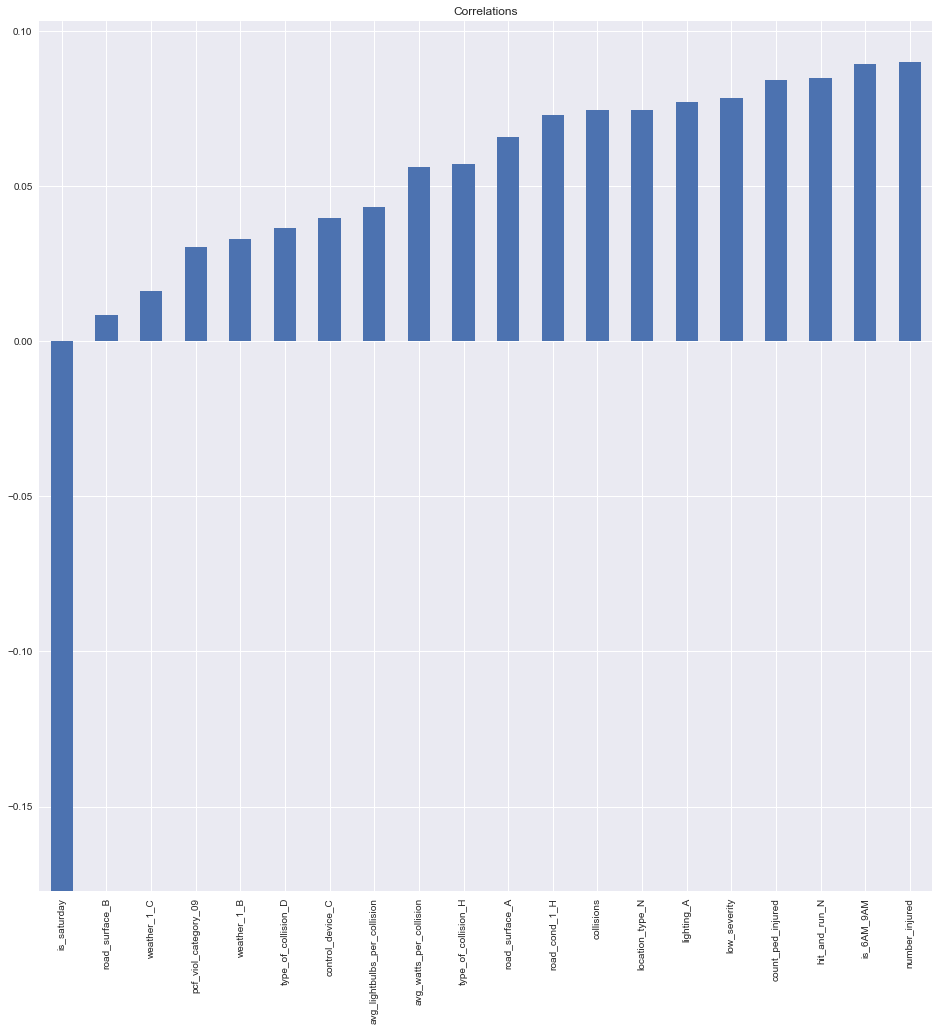

In [248]:
correlated_with_y = sector1_df.corr()['collisions_tomorrow'].sort_values()
%matplotlib inline
correlated_with_y.iloc[:-1].plot(kind='bar',
title='Correlations', figsize=(16,16))

### If you need a new model for a sector
tpot = TPOTRegressor(verbosity=2, generations=5)

tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

tpot.export('tpot_pipeline.py')


# Old Code and Notes

### Decide Which Models will be used

- Random Forest
- Linear Regression
- Decision tree
- KNN
- SVR
- Adaboost
- Baseline
- GradientBoostingRegressor 
- GaussianProcessRegressor
- LinearSVR
- Ridge Regression
- Lasso
- try XGBoost, ann and deep learning


### Decide Which Hyperparameters to Tune for Each Model

- Use Grid search
- Random Forest (max_features: auto, sqrt, log2, 0.2 / n_estimators: 100, 300, 700 / min_sample_leaf: 60, 100, 140, 180, criterion: ?)
- Linear Regression (learning rate, not sure ?)
- Decision tree(max_depth; deeper the tree, more info about the data, min_samples_split, min_smaples-leaf, max_features)
- KNN(n_neighbors, p in L-p distance)
- SVR(C (GridSearch), epsilon, and, assuming you use an RBF kernel function, gamma)
- Adaboost (Learning Rate(try 0.01 during modelling and set it very small 0.0001 later), maximum_no._of_splits, no. of weak learners should be high)
- Baseline(N/A)
- GradientBoostingRegressor (learning_rate, n_estimators, max_depth,min_samples_split,min_samples_leaf,max_features)
- GaussianProcessRegressor (learning_rate, regularization,Kernel)
- LinearSVR(open tab)
- Ridge Regression
- alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
- Lasso
- alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

### Do Feature selection, anything allowed

- Best [100, 75, 50, 25, 12] variables used
- Only choose the features once
- Run this cell and those below when you decide to change the # of features to use

In [ ]:

# # NOTE: Make sure that the class is labeled 'target' in the data file
# #tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# #features = tpot_data.drop('target', axis=1).values
# #training_features, testing_features, training_target, testing_target = \
#            # train_test_split(features, tpot_data['target'].values, random_state=42)

# # Score on the training set was:-0.13621358017694313
# exported_pipeline = make_pipeline(
#     StackingEstimator(estimator=RidgeCV()),
#     XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
# )

# exported_pipeline.fit( X_train,y_train)
# results = exported_pipeline.predict(X_test)
# df = pd.DataFrame()
# df['y_test'] = y_test
# df['results'] = results
# df.to_csv('test_result.csv')

# from sklearn.ensemble import RandomForestRegressor

# my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
#                                         bootstrap = True,random_state=2)

# #train the RandomForest alg by using the FIT method

# my_RandomForest.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained RandomForest alg using the testing sample:

# y_predict = my_RandomForest.predict(X_test)

# # print(y_predict)


# # Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# # portion of correct predictions:
# from sklearn.metrics import mean_squared_error
# mse_RF = mean_squared_error(y_test, y_predict)
# print(mse_RF)

# from sklearn.neural_network import MLPRegressor

# my_ANN = MLPRegressor(hidden_layer_sizes=(6,4), activation= 'logistic', 
#                        solver='lbfgs', alpha=1e-5, random_state=1 )


# # Training ONLY on the training set:
# my_ANN.fit(X_transform, y_train)

# # Weights:
# print(my_ANN.coefs_)
# # The ith element in the list represents the weight matrix corresponding to layer i.

# print('\n')

# # Bias weights:
# print(my_ANN.intercepts_)
# # The ith element in the list represents the bias vector corresponding to layer i + 1.

# # Testing on the testing set:
# y_predict_ann = my_ANN.predict(X_transform_test)
# print(y_predict_ann)

# # We can now compare the "predicted labels" for the Testing Set with its "actual labels" to evaluate the accuracy 

# mse_ann = mean_squared_error(y_test, y_predict_ann)
# print(mse_ann)




# # Adaboost (Learning Rate(try 0.01 during modelling and set it very small 0.0001 later), maximum_no._of_splits, no. of weak learners should be high)
# # Baseline(N/A)

# # Adaboost is a classifier which gives weightage to each features and reduces the errors in getting the best prediction

# from sklearn.ensemble import AdaBoostRegressor

# my_AdaBoost = AdaBoostRegressor(n_estimators=500, random_state=2)

# #train the adaboost alg by using the FIT method

# my_AdaBoost.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained Adaboost alg using the testing sample:

# y_adaboost_predict = my_AdaBoost.predict(X_test)

# # print(y_adaboost_predict)
# print(y_adaboost_predict.shape)

# adaboost_mse = mean_squared_error(y_test, y_adaboost_predict)

# print(adaboost_mse)


# # Best pipeline: XGBRegressor(RidgeCV(input_matrix), learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.55)
# # -0.114416034755
# -0.114416034755

# # Best so Far
# - 10.89: 240, log2, 5 (using 100 best features and no PCA)
# - .732: 1000, log2, 5 (20 features and 8 PCA)

# from sklearn.ensemble import RandomForestRegressor

# my_RandomForest = RandomForestRegressor(n_estimators = 1000, max_features="log2", min_samples_leaf=5, criterion="mse", 
#                                         bootstrap = True,random_state=2)

# #train the RandomForest alg by using the FIT method

# my_RandomForest.fit(X_train,y_train,sample_weight=None)

# #Make prediction over the trained RandomForest alg using the testing sample:

# y_predict = my_RandomForest.predict(X_test)

# # print(y_predict)


# # Function "accuracy_score" from "sklearn.metrics" will perform the element-to-element comparision and returns the 
# # portion of correct predictions:
# from sklearn.metrics import mean_squared_error
# mse_RF = mean_squared_error(y_test, y_predict)
# print(mse_RF)

# from sklearn.linear_model import LinearRegression
# # In the following line, "my_linreg" is instantiated as an "object" of LinearRegression "class". 

# my_linreg = LinearRegression()

# # fitting the model to the training data:
# my_linreg.fit(X_train, y_train)

# # printing Theta0 using attribute "intercept_":
# #print(my_linreg.intercept_)

# # printing [Theta1, Theta2, Theta3, Theta4, Theta5, Theta6, Theta7] using attribute "coef_":
# #print(my_linreg.coef_)

#  # make predictions on the testing set
# y_prediction = my_linreg.predict(X_test)

# # print(y_prediction)

# from sklearn import metrics
# import numpy as np

# # Calculating "Mean Square Error" (MSE):
# mse = metrics.mean_squared_error(y_test, y_prediction)

# # Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
# rmse = np.sqrt(mse)

# print("mse is ", mse)



# mse_RF = mean_squared_error(y_train, my_RandomForest.predict(X_train))
# print(mse_RF)


# my_RandomForest.score(X_test,y_test)

# my_RandomForest

